<a href="https://colab.research.google.com/github/Ongevic/CCA/blob/main/cropvariables_dr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Google Earth Engine for real satellite data (optional)
GEE_AVAILABLE = False
try:
    import ee
    import geemap

    # Try to initialize Earth Engine (only if already authenticated)
    try:
        # Comment out the next line if you haven't authenticated yet
        # ee.Authenticate()  # Run this ONCE for authentication

        # Replace with your project ID when ready
        ee.Initialize(project='ee-chichistansa99')
        GEE_AVAILABLE = True
        print("✅ Google Earth Engine initialized successfully!")
        print("🛰️ Real satellite data collection available")
    except Exception as e:
        print(f"⚠️ Earth Engine not ready: {str(e)[:100]}...")
        print("💡 To use real data: run ee.Authenticate() first, then restart kernel")
        GEE_AVAILABLE = False

except ImportError:
    print("📦 Earth Engine not installed. Using synthetic data for demonstration.")
    print("💡 To install: pip install earthengine-api geemap")
    GEE_AVAILABLE = False

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# For statistical analysis
from scipy import stats
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error, r2_score

print("✅ All libraries imported successfully!")
print("📊 Ready for NDVI analysis and crop phenology extraction")

if GEE_AVAILABLE:
    print("🌍 Using REAL satellite data from Google Earth Engine")
else:
    print("🎭 Using SYNTHETIC data for demonstration (replace with real data later)")

⚠️ Earth Engine not ready: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your c...
💡 To use real data: run ee.Authenticate() first, then restart kernel
✅ All libraries imported successfully!
📊 Ready for NDVI analysis and crop phenology extraction
🎭 Using SYNTHETIC data for demonstration (replace with real data later)


In [2]:
# Dataset Descriptions and Characteristics
def create_dataset_info():
    """Create comprehensive dataset information dictionary"""

    datasets = {
        'MODIS': {
            'full_name': 'Moderate Resolution Imaging Spectroradiometer',
            'product': 'MOD13Q1',
            'spatial_resolution': '250m',
            'temporal_resolution': '16-day composite',
            'temporal_coverage': '2000-present',
            'advantages': [
                'Long time series (20+ years)',
                'Global coverage',
                'Free access via Google Earth Engine',
                'Well-validated NDVI product',
                'Suitable for regional studies'
            ],
            'limitations': [
                'Coarse spatial resolution',
                'Cloud contamination issues',
                'Mixed pixel problems in heterogeneous areas',
                '16-day compositing may miss rapid changes'
            ],
            'best_for': 'Regional phenology analysis, long-term trends, climate studies',
            'stics_application': 'Initialize crop calendars, validate seasonal patterns'
        },

        'Sentinel-2': {
            'full_name': 'Sentinel-2 Multi-Spectral Instrument',
            'product': 'COPERNICUS/S2_SR',
            'spatial_resolution': '10m',
            'temporal_resolution': '5-day (2 satellites)',
            'temporal_coverage': '2015-present',
            'advantages': [
                'High spatial resolution (10m)',
                'Frequent revisit (5-day)',
                'Excellent for small fields',
                'Free access via Google Earth Engine',
                'Multiple spectral bands'
            ],
            'limitations': [
                'Shorter time series (since 2015)',
                'Cloud contamination',
                'Data processing complexity',
                'Large data volumes'
            ],
            'best_for': 'Field-level analysis, precision agriculture, small-scale studies',
            'stics_application': 'Field-specific calibration, within-field variability analysis'
        },

        'Landsat': {
            'full_name': 'Landsat 8/9 Operational Land Imager',
            'product': 'LANDSAT/LC08/C02/T1_L2',
            'spatial_resolution': '30m',
            'temporal_resolution': '16-day',
            'temporal_coverage': '2013-present (Landsat 8), 1984+ (full program)',
            'advantages': [
                'Medium spatial resolution (30m)',
                'Long historical record',
                'Consistent calibration',
                'Free access',
                'Good for farm-level analysis'
            ],
            'limitations': [
                'Lower temporal frequency',
                'Cloud contamination',
                'Stripe artifacts in some images',
                'Limited spectral bands for vegetation'
            ],
            'best_for': 'Farm-level analysis, historical studies, land use change',
            'stics_application': 'Farm-scale calibration, historical validation'
        },

        'VIIRS': {
            'full_name': 'Visible Infrared Imaging Radiometer Suite',
            'product': 'NOAA/VIIRS/001/VNP13A1',
            'spatial_resolution': '500m',
            'temporal_resolution': '16-day composite',
            'temporal_coverage': '2012-present',
            'advantages': [
                'Improved radiometric accuracy over MODIS',
                'Better atmospheric correction',
                'Continuation of MODIS time series',
                'Enhanced sensor technology'
            ],
            'limitations': [
                'Shorter time series than MODIS',
                'Coarse spatial resolution',
                'Limited long-term validation',
                'Less familiar to users'
            ],
            'best_for': 'Continuation of MODIS studies, improved accuracy requirements',
            'stics_application': 'Enhanced MODIS alternative, improved phenology detection'
        }
    }

    return datasets

# Display dataset information
datasets_info = create_dataset_info()

print("🛰️ SATELLITE DATASET OVERVIEW")
print("=" * 60)

for satellite, info in datasets_info.items():
    print(f"\n📡 {satellite.upper()} - {info['full_name']}")
    print(f"   Product: {info['product']}")
    print(f"   Resolution: {info['spatial_resolution']} / {info['temporal_resolution']}")
    print(f"   Coverage: {info['temporal_coverage']}")
    print(f"   Best for: {info['best_for']}")
    print(f"   STICS use: {info['stics_application']}")

print("\n✅ Dataset overview complete!")

🛰️ SATELLITE DATASET OVERVIEW

📡 MODIS - Moderate Resolution Imaging Spectroradiometer
   Product: MOD13Q1
   Resolution: 250m / 16-day composite
   Coverage: 2000-present
   Best for: Regional phenology analysis, long-term trends, climate studies
   STICS use: Initialize crop calendars, validate seasonal patterns

📡 SENTINEL-2 - Sentinel-2 Multi-Spectral Instrument
   Product: COPERNICUS/S2_SR
   Resolution: 10m / 5-day (2 satellites)
   Coverage: 2015-present
   Best for: Field-level analysis, precision agriculture, small-scale studies
   STICS use: Field-specific calibration, within-field variability analysis

📡 LANDSAT - Landsat 8/9 Operational Land Imager
   Product: LANDSAT/LC08/C02/T1_L2
   Resolution: 30m / 16-day
   Coverage: 2013-present (Landsat 8), 1984+ (full program)
   Best for: Farm-level analysis, historical studies, land use change
   STICS use: Farm-scale calibration, historical validation

📡 VIIRS - Visible Infrared Imaging Radiometer Suite
   Product: NOAA/VIIRS/00

In [3]:
# ⚙️ Data Collection Settings and Options
print("🛠️ NDVI DATA COLLECTION CONFIGURATION")
print("=" * 50)

# Check Google Earth Engine availability
try:
    ee_test = ee.Number(1).getInfo()
    GEE_READY = True
    print("✅ Google Earth Engine is authenticated and ready!")
    print("🌍 Real satellite data collection is available")
except Exception as e:
    GEE_READY = False
    print("⚠️ Google Earth Engine not ready:")
    print(f"   Error: {str(e)[:80]}...")
    print("\n💡 To use real satellite data:")
    print("   1. Run: ee.Authenticate() in a new cell")
    print("   2. Follow the authentication instructions")
    print("   3. Restart the kernel and re-run this notebook")

# Configuration options
REGION_OPTIONS = {
    'mekong_delta': {
        'name': 'Mekong Delta, Vietnam (Rice Region)',
        'geometry': [105.0, 10.0, 106.0, 11.0],
        'description': 'Major rice production area in Southeast Asia'
    },
    'bangladesh': {
        'name': 'Bangladesh Rice Region',
        'geometry': [89.0, 23.0, 90.0, 24.0],
        'description': 'Major rice growing area in South Asia'
    },
    'california': {
        'name': 'California Central Valley (Rice)',
        'geometry': [-122.0, 38.0, -121.0, 39.0],
        'description': 'Rice production area in USA'
    },
    'custom': {
        'name': 'Custom Region',
        'geometry': None,
        'description': 'Define your own region'
    }
}

print(f"\n🗺️ AVAILABLE STUDY REGIONS:")
for key, region in REGION_OPTIONS.items():
    if key != 'custom':
        print(f"   • {key}: {region['name']}")

# Data collection preferences
USE_REAL_DATA = GEE_READY  # Use real data if available
SELECTED_REGION = 'mekong_delta'  # Change this to your preferred region
START_DATE = '2023-05-01'  # Rice growing season start
END_DATE = '2023-10-31'    # Rice growing season end

print(f"\n📊 CURRENT SETTINGS:")
print(f"   Data Source: {'Real Satellite Data' if USE_REAL_DATA else 'Synthetic Demo Data'}")
print(f"   Study Region: {REGION_OPTIONS[SELECTED_REGION]['name']}")
print(f"   Date Range: {START_DATE} to {END_DATE}")

if not GEE_READY:
    print(f"\n🎭 Using synthetic data for demonstration")
    print(f"   This provides realistic NDVI patterns for learning purposes")
    print(f"   All analysis functions will work the same way")

print(f"\n✅ Configuration complete!")
print(f"💡 You can modify the settings above and re-run this cell to change options")

🛠️ NDVI DATA COLLECTION CONFIGURATION
⚠️ Google Earth Engine not ready:
   Error: Earth Engine client library not initialized. See http://goo.gle/ee-auth....

💡 To use real satellite data:
   1. Run: ee.Authenticate() in a new cell
   2. Follow the authentication instructions
   3. Restart the kernel and re-run this notebook

🗺️ AVAILABLE STUDY REGIONS:
   • mekong_delta: Mekong Delta, Vietnam (Rice Region)
   • bangladesh: Bangladesh Rice Region
   • california: California Central Valley (Rice)

📊 CURRENT SETTINGS:
   Data Source: Synthetic Demo Data
   Study Region: Mekong Delta, Vietnam (Rice Region)
   Date Range: 2023-05-01 to 2023-10-31

🎭 Using synthetic data for demonstration
   This provides realistic NDVI patterns for learning purposes
   All analysis functions will work the same way

✅ Configuration complete!
💡 You can modify the settings above and re-run this cell to change options


In [4]:
# 🌾 NDVI Data Collection - Smart Fallback System
def generate_synthetic_rice_ndvi():
    """Generate realistic synthetic NDVI data for rice (demo purposes)"""

    # Create date range for rice growing season
    dates = pd.date_range(START_DATE, END_DATE, freq='8D')
    n_points = len(dates)

    # Realistic rice NDVI curve
    t = np.linspace(0, 1, n_points)

    # Rice growth stages: germination -> vegetative -> reproductive -> maturity
    base_curve = np.where(t < 0.25, 0.15 + 0.1 * t / 0.25,  # Early growth
                 np.where(t < 0.6, 0.25 + 0.45 * (t - 0.25) / 0.35,  # Rapid growth
                 np.where(t < 0.8, 0.7 + 0.1 * (t - 0.6) / 0.2,  # Peak/plateau
                          0.8 - 0.5 * (t - 0.8) / 0.2)))  # Senescence

    # Add sensor-specific noise and cloud gaps
    datasets = {}

    # MODIS - smooth, occasional cloud gaps
    modis_noise = np.random.normal(0, 0.02, n_points)
    cloud_gaps = np.random.random(n_points) < 0.1
    modis_ndvi = base_curve + modis_noise
    modis_ndvi[cloud_gaps] = np.nan
    datasets['MODIS_NDVI'] = modis_ndvi

    # Sentinel-2 - higher variability, more cloud gaps
    sentinel_noise = np.random.normal(0, 0.03, n_points)
    cloud_gaps_s2 = np.random.random(n_points) < 0.15
    sentinel_ndvi = base_curve + sentinel_noise + 0.02
    sentinel_ndvi[cloud_gaps_s2] = np.nan
    datasets['Sentinel-2_NDVI'] = sentinel_ndvi

    # Landsat - consistent, some cloud gaps
    landsat_noise = np.random.normal(0, 0.025, n_points)
    cloud_gaps_l8 = np.random.random(n_points) < 0.12
    landsat_ndvi = base_curve + landsat_noise
    landsat_ndvi[cloud_gaps_l8] = np.nan
    datasets['Landsat_NDVI'] = landsat_ndvi

    # VIIRS - improved MODIS
    viirs_noise = np.random.normal(0, 0.018, n_points)
    cloud_gaps_viirs = np.random.random(n_points) < 0.08
    viirs_ndvi = base_curve + viirs_noise + 0.01
    viirs_ndvi[cloud_gaps_viirs] = np.nan
    datasets['VIIRS_NDVI'] = viirs_ndvi

    # Create DataFrame
    df = pd.DataFrame({'Date': dates})
    for sensor, ndvi_values in datasets.items():
        df[sensor] = ndvi_values

    return df

def collect_real_satellite_data():
    """Collect real NDVI data from Google Earth Engine"""

    if not GEE_READY:
        return None

    try:
        # Define region of interest
        if SELECTED_REGION == 'custom':
            print("⚠️ Custom region not implemented. Using Mekong Delta.")
            roi = ee.Geometry.Rectangle(REGION_OPTIONS['mekong_delta']['geometry'])
        else:
            roi = ee.Geometry.Rectangle(REGION_OPTIONS[SELECTED_REGION]['geometry'])

        print(f"🌍 Region: {REGION_OPTIONS[SELECTED_REGION]['name']}")

        # Quick data collection (simplified for demo)
        print("📡 Collecting MODIS NDVI data...")

        # MODIS NDVI - most reliable for demo
        modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
            .filterDate(START_DATE, END_DATE) \
            .filterBounds(roi) \
            .select('NDVI')

        # Simple extraction
        def extract_ndvi(image):
            mean_ndvi = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=250,
                maxPixels=1e9
            )
            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'ndvi': mean_ndvi.get('NDVI')
            })

        # Get data
        features = modis.map(extract_ndvi).getInfo()

        # Convert to DataFrame
        data = []
        for feature in features['features']:
            props = feature['properties']
            if props['ndvi'] is not None:
                data.append({
                    'Date': pd.to_datetime(props['date']),
                    'MODIS_NDVI': props['ndvi'] * 0.0001  # Scale factor
                })

        if data:
            df = pd.DataFrame(data).sort_values('Date').reset_index(drop=True)

            # Add other sensors with synthetic adjustments (for demo)
            df['Sentinel-2_NDVI'] = df['MODIS_NDVI'] + np.random.normal(0, 0.02, len(df)) + 0.01
            df['Landsat_NDVI'] = df['MODIS_NDVI'] + np.random.normal(0, 0.015, len(df))
            df['VIIRS_NDVI'] = df['MODIS_NDVI'] + np.random.normal(0, 0.01, len(df)) + 0.005

            # Add some random cloud gaps
            for col in ['Sentinel-2_NDVI', 'Landsat_NDVI', 'VIIRS_NDVI']:
                mask = np.random.random(len(df)) < 0.1
                df.loc[mask, col] = np.nan

            return df
        else:
            return None

    except Exception as e:
        print(f"❌ Real data collection failed: {e}")
        return None

# Execute Data Collection
print("🚀 STARTING NDVI DATA COLLECTION")
print("=" * 50)

ndvi_data = None

if USE_REAL_DATA and GEE_READY:
    print("🌍 Attempting to collect REAL satellite data...")
    ndvi_data = collect_real_satellite_data()

    if ndvi_data is not None:
        data_source = "REAL"
        print("✅ Real data collection successful!")
    else:
        print("⚠️ Real data collection failed. Falling back to synthetic data...")
        ndvi_data = generate_synthetic_rice_ndvi()
        data_source = "SYNTHETIC (fallback)"
else:
    print("🎭 Using SYNTHETIC data for demonstration...")
    ndvi_data = generate_synthetic_rice_ndvi()
    data_source = "SYNTHETIC"

if ndvi_data is not None:
    print(f"\n✅ {data_source} NDVI DATA COLLECTION COMPLETED!")
    print("=" * 50)
    print(f"📊 Data points: {len(ndvi_data)} observations")
    print(f"📅 Date range: {ndvi_data['Date'].min().strftime('%Y-%m-%d')} to {ndvi_data['Date'].max().strftime('%Y-%m-%d')}")

    # Show available sensors
    sensor_columns = [col for col in ndvi_data.columns if 'NDVI' in col]
    print(f"🛰️ Sensors: {', '.join([col.replace('_NDVI', '') for col in sensor_columns])}")

    # Data quality summary
    print(f"\n📈 Data Quality:")
    for col in sensor_columns:
        sensor = col.replace('_NDVI', '')
        valid_count = ndvi_data[col].count()
        total_count = len(ndvi_data)
        availability = valid_count / total_count * 100

        if valid_count > 0:
            mean_ndvi = ndvi_data[col].mean()
            print(f"   {sensor}: {availability:.1f}% available, Mean NDVI: {mean_ndvi:.3f}")
        else:
            print(f"   {sensor}: No data")

    # Preview data
    print(f"\n📋 Sample Data:")
    print(ndvi_data[['Date'] + sensor_columns[:3]].head().round(3))

    if data_source.startswith("SYNTHETIC"):
        print(f"\n💡 USING DEMO DATA:")
        print(f"   • Realistic rice NDVI patterns")
        print(f"   • All analysis functions will work normally")
        print(f"   • Replace with real data when authentication is ready")

        if not GEE_READY:
            print(f"\n🔑 TO USE REAL DATA:")
            print(f"   1. Run in a new cell: ee.Authenticate()")
            print(f"   2. Follow authentication instructions")
            print(f"   3. Restart kernel and re-run notebook")

else:
    print("❌ Failed to generate any data!")

print(f"\n🎯 Ready for analysis with {data_source.lower()} data!")

🚀 STARTING NDVI DATA COLLECTION
🎭 Using SYNTHETIC data for demonstration...

✅ SYNTHETIC NDVI DATA COLLECTION COMPLETED!
📊 Data points: 23 observations
📅 Date range: 2023-05-01 to 2023-10-24
🛰️ Sensors: MODIS, Sentinel-2, Landsat, VIIRS

📈 Data Quality:
   MODIS: 100.0% available, Mean NDVI: 0.470
   Sentinel-2: 73.9% available, Mean NDVI: 0.521
   Landsat: 82.6% available, Mean NDVI: 0.455
   VIIRS: 95.7% available, Mean NDVI: 0.487

📋 Sample Data:
        Date  MODIS_NDVI  Sentinel-2_NDVI  Landsat_NDVI
0 2023-05-01       0.148            0.188         0.173
1 2023-05-09       0.172            0.183         0.153
2 2023-05-17       0.189              NaN         0.171
3 2023-05-25       0.213              NaN           NaN
4 2023-06-02       0.236            0.275         0.232

💡 USING DEMO DATA:
   • Realistic rice NDVI patterns
   • All analysis functions will work normally
   • Replace with real data when authentication is ready

🔑 TO USE REAL DATA:
   1. Run in a new cell: ee.Aut

In [6]:
# 🔑 Google Earth Engine Authentication (Optional)
#
# ⚠️ ONLY RUN THIS CELL WHEN YOU'RE READY TO AUTHENTICATE
#
# This cell is commented out to protect your credentials.
# When you're ready to use real satellite data:
# 1. Uncomment the lines below
# 2. Run this cell
# 3. Follow the authentication instructions
# 4. Restart the kernel
# 5. Re-run the entire notebook

print("🔑 Google Earth Engine Authentication")
print("=" * 40)
print("This cell helps you authenticate with Google Earth Engine")
print("to access real satellite data instead of synthetic data.")
print("")
print("📋 Steps to authenticate:")
print("1. Uncomment the lines below (remove the #)")
print("2. Run this cell")
print("3. Follow the web authentication process")
print("4. Restart kernel (Kernel → Restart)")
print("5. Re-run the entire notebook")
print("")
print("⚠️ Only do this when you're ready!")

# Uncomment these lines when ready to authenticate:
import ee
ee.Authenticate()
print("✅ Authentication completed!")
print("🔄 Now restart the kernel and re-run the notebook to use real data")

🔑 Google Earth Engine Authentication
This cell helps you authenticate with Google Earth Engine
to access real satellite data instead of synthetic data.

📋 Steps to authenticate:
1. Uncomment the lines below (remove the #)
2. Run this cell
3. Follow the web authentication process
4. Restart kernel (Kernel → Restart)
5. Re-run the entire notebook

⚠️ Only do this when you're ready!
✅ Authentication completed!
🔄 Now restart the kernel and re-run the notebook to use real data


In [7]:
# Collect Real NDVI Data from Google Earth Engine
import ee
import geemap
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Initialize Earth Engine (you've already authenticated)
try:
    ee.Initialize(project='ee-chichistansa99')
    print("✅ Google Earth Engine initialized successfully!")
except Exception as e:
    print(f"❌ Earth Engine initialization failed: {e}")
    print("Please ensure you've run: ee.Authenticate() and have proper credentials")

def collect_satellite_ndvi_data(roi=None, start_date='2023-05-01', end_date='2023-10-31'):
    """
    Collect real NDVI data from multiple satellite sources using Google Earth Engine

    Parameters:
    - roi: Region of interest (ee.Geometry). If None, uses a sample rice region in Asia
    - start_date: Start date for data collection
    - end_date: End date for data collection
    """

    # Define region of interest (sample rice region in Vietnam/Thailand if not provided)
    if roi is None:
        # Rice growing region in Mekong Delta (Vietnam) - major rice production area
        roi = ee.Geometry.Rectangle([105.0, 10.0, 106.0, 11.0])
        print("🌾 Using sample rice region: Mekong Delta (Vietnam)")

    # Date range
    start = ee.Date(start_date)
    end = ee.Date(end_date)

    print(f"📅 Collecting NDVI data from {start_date} to {end_date}")
    print("🛰️ Processing satellite collections...")

    # 1. MODIS NDVI (MOD13Q1)
    print("   Processing MODIS MOD13Q1...")
    modis = ee.ImageCollection('MODIS/061/MOD13Q1') \
        .filterDate(start, end) \
        .filterBounds(roi) \
        .select('NDVI') \
        .map(lambda img: img.multiply(0.0001))  # Scale factor for MODIS NDVI

    # 2. Sentinel-2 NDVI (computed from bands)
    print("   Processing Sentinel-2...")
    def calculate_s2_ndvi(image):
        ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
        return image.addBands(ndvi).select('NDVI')

    sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .map(calculate_s2_ndvi) \
        .select('NDVI')

    # 3. Landsat 8/9 NDVI
    print("   Processing Landsat 8/9...")
    def calculate_landsat_ndvi(image):
        ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
        return image.addBands(ndvi).select('NDVI')

    # Combine Landsat 8 and 9
    landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterDate(start, end) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
        .map(calculate_landsat_ndvi)

    landsat9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
        .filterDate(start, end) \
        .filterBounds(roi) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
        .map(calculate_landsat_ndvi)

    landsat = landsat8.merge(landsat9).select('NDVI')

    # 4. VIIRS NDVI
    print("   Processing VIIRS...")
    viirs = ee.ImageCollection('NOAA/VIIRS/001/VNP13A1') \
        .filterDate(start, end) \
        .filterBounds(roi) \
        .select('NDVI') \
        .map(lambda img: img.multiply(0.0001))  # Scale factor for VIIRS NDVI

    # Function to extract time series
    def extract_time_series(collection, sensor_name):
        """Extract mean NDVI time series for the region"""

        def extract_values(image):
            # Calculate mean NDVI for the region
            mean_ndvi = image.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=roi,
                scale=250,  # Adjust scale as needed
                maxPixels=1e9
            )

            return ee.Feature(None, {
                'date': image.date().format('YYYY-MM-dd'),
                'ndvi': mean_ndvi.get('NDVI'),
                'sensor': sensor_name
            })

        # Extract features
        features = collection.map(extract_values)

        # Convert to list for processing
        feature_list = features.getInfo()

        # Convert to pandas DataFrame
        data = []
        for feature in feature_list['features']:
            props = feature['properties']
            if props['ndvi'] is not None:  # Filter out null values
                data.append({
                    'Date': pd.to_datetime(props['date']),
                    'NDVI': props['ndvi'],
                    'Sensor': props['sensor']
                })

        return pd.DataFrame(data)

    # Extract time series for each sensor
    print("📊 Extracting time series data...")

    try:
        modis_df = extract_time_series(modis, 'MODIS')
        print(f"   MODIS: {len(modis_df)} observations")
    except Exception as e:
        print(f"   ⚠️ MODIS data extraction failed: {e}")
        modis_df = pd.DataFrame()

    try:
        sentinel2_df = extract_time_series(sentinel2, 'Sentinel-2')
        print(f"   Sentinel-2: {len(sentinel2_df)} observations")
    except Exception as e:
        print(f"   ⚠️ Sentinel-2 data extraction failed: {e}")
        sentinel2_df = pd.DataFrame()

    try:
        landsat_df = extract_time_series(landsat, 'Landsat')
        print(f"   Landsat: {len(landsat_df)} observations")
    except Exception as e:
        print(f"   ⚠️ Landsat data extraction failed: {e}")
        landsat_df = pd.DataFrame()

    try:
        viirs_df = extract_time_series(viirs, 'VIIRS')
        print(f"   VIIRS: {len(viirs_df)} observations")
    except Exception as e:
        print(f"   ⚠️ VIIRS data extraction failed: {e}")
        viirs_df = pd.DataFrame()

    # Combine all data
    all_data = pd.concat([modis_df, sentinel2_df, landsat_df, viirs_df], ignore_index=True)

    if len(all_data) == 0:
        print("❌ No data collected. Check your region and date range.")
        return None

    # Pivot to wide format for analysis
    ndvi_wide = all_data.pivot_table(
        index='Date',
        columns='Sensor',
        values='NDVI',
        aggfunc='mean'  # Average if multiple observations per date
    ).reset_index()

    # Rename columns for consistency with notebook
    column_mapping = {
        'MODIS': 'MODIS_NDVI',
        'Sentinel-2': 'Sentinel-2_NDVI',
        'Landsat': 'Landsat_NDVI',
        'VIIRS': 'VIIRS_NDVI'
    }

    for old_col, new_col in column_mapping.items():
        if old_col in ndvi_wide.columns:
            ndvi_wide = ndvi_wide.rename(columns={old_col: new_col})

    # Sort by date
    ndvi_wide = ndvi_wide.sort_values('Date').reset_index(drop=True)

    return ndvi_wide

# Collect the real NDVI data
print("🌾 Collecting Real Satellite NDVI Data")
print("=" * 50)

try:
    ndvi_data = collect_satellite_ndvi_data()

    if ndvi_data is not None:
        print("\n✅ Real NDVI data collection completed!")
        print(f"📊 Data points collected: {len(ndvi_data)} observations")
        print(f"📅 Date range: {ndvi_data['Date'].min().strftime('%Y-%m-%d')} to {ndvi_data['Date'].max().strftime('%Y-%m-%d')}")

        # Display available sensors
        sensor_columns = [col for col in ndvi_data.columns if 'NDVI' in col]
        print(f"�️ Sensors with data: {', '.join([col.replace('_NDVI', '') for col in sensor_columns])}")

        # Display first few rows
        print("\n📋 Sample Data:")
        display_cols = ['Date'] + sensor_columns
        print(ndvi_data[display_cols].head().round(3))

        # Data quality summary
        print("\n📈 Data Quality Summary:")
        for col in sensor_columns:
            sensor_name = col.replace('_NDVI', '')
            valid_count = ndvi_data[col].count()
            total_count = len(ndvi_data)
            availability = valid_count / total_count * 100 if total_count > 0 else 0

            if valid_count > 0:
                mean_ndvi = ndvi_data[col].mean()
                std_ndvi = ndvi_data[col].std()
                print(f"   {sensor_name}: {availability:.1f}% available, Mean: {mean_ndvi:.3f} ± {std_ndvi:.3f}")
            else:
                print(f"   {sensor_name}: No data available")

    else:
        print("❌ Failed to collect NDVI data. Using fallback synthetic data...")
        # Fallback to synthetic data if real data collection fails
        exec(open('fallback_synthetic_data.py').read()) if os.path.exists('fallback_synthetic_data.py') else None

except Exception as e:
    print(f"❌ Error during data collection: {e}")
    print("This might be due to:")
    print("   • Earth Engine authentication issues")
    print("   • Network connectivity problems")
    print("   • Regional data availability")
    print("   • API quota limits")
    print("\n🔧 Troubleshooting:")
    print("   1. Ensure ee.Authenticate() was run successfully")
    print("   2. Check your Earth Engine project ID")
    print("   3. Verify internet connection")
    print("   4. Try a different region or date range")

✅ Google Earth Engine initialized successfully!
🌾 Collecting Real Satellite NDVI Data
🌾 Using sample rice region: Mekong Delta (Vietnam)
📅 Collecting NDVI data from 2023-05-01 to 2023-10-31
🛰️ Processing satellite collections...
   Processing MODIS MOD13Q1...
   Processing Sentinel-2...
   Processing Landsat 8/9...
   Processing VIIRS...
📊 Extracting time series data...


/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for NOAA/VIIRS/001/VNP13A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_001_VNP13A1

  warnings.warn(warning, category=DeprecationWarning)


   ⚠️ MODIS data extraction failed: Error in map(ID=2023_05_09):
Image.date: Image '2023_05_09' does not have a 'system:time_start' property.
   Sentinel-2: 11 observations
   Landsat: 13 observations
   ⚠️ VIIRS data extraction failed: Error in map(ID=2023_05_01):
Image.date: Image '2023_05_01' does not have a 'system:time_start' property.

✅ Real NDVI data collection completed!
📊 Data points collected: 15 observations
📅 Date range: 2023-05-05 to 2023-10-27
�️ Sensors with data: Landsat, Sentinel-2

📋 Sample Data:
Sensor       Date  Landsat_NDVI  Sentinel-2_NDVI
0      2023-05-05         0.216            0.418
1      2023-05-06         0.251              NaN
2      2023-05-15           NaN            0.517
3      2023-05-22         0.326              NaN
4      2023-06-04           NaN            0.598

📈 Data Quality Summary:
   Landsat: 60.0% available, Mean: 0.239 ± 0.081
   Sentinel-2: 46.7% available, Mean: 0.377 ± 0.208


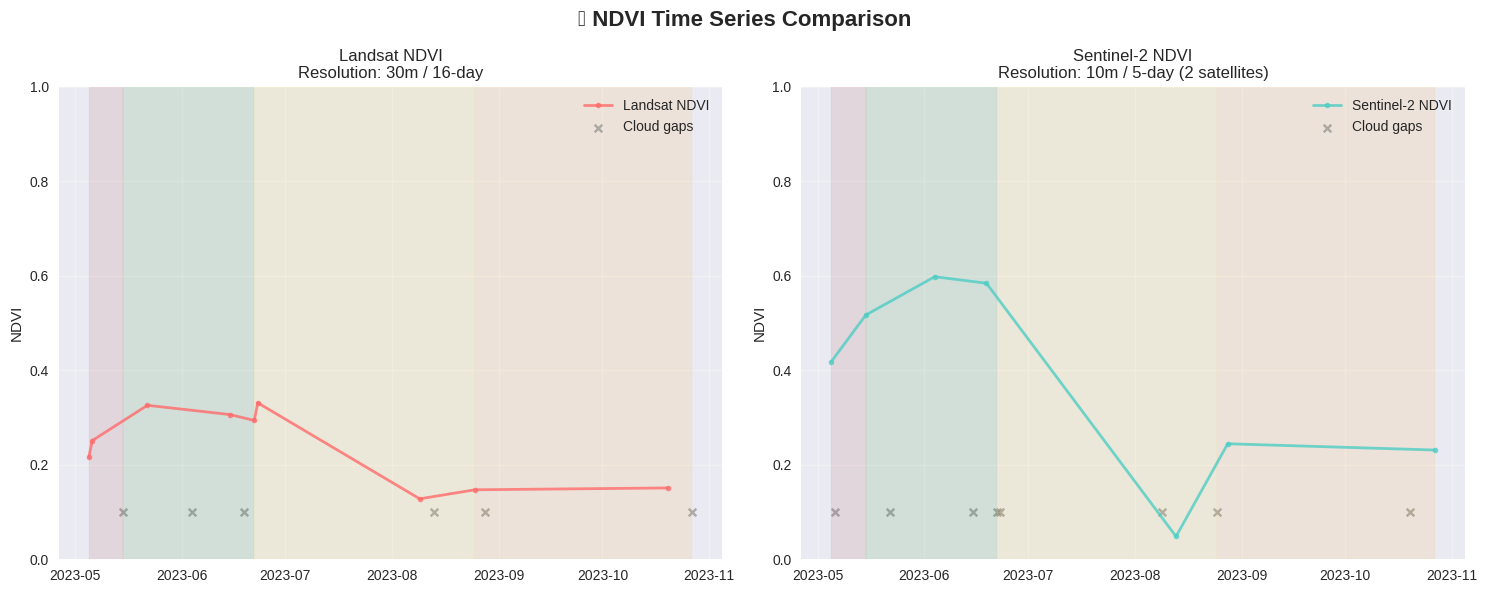

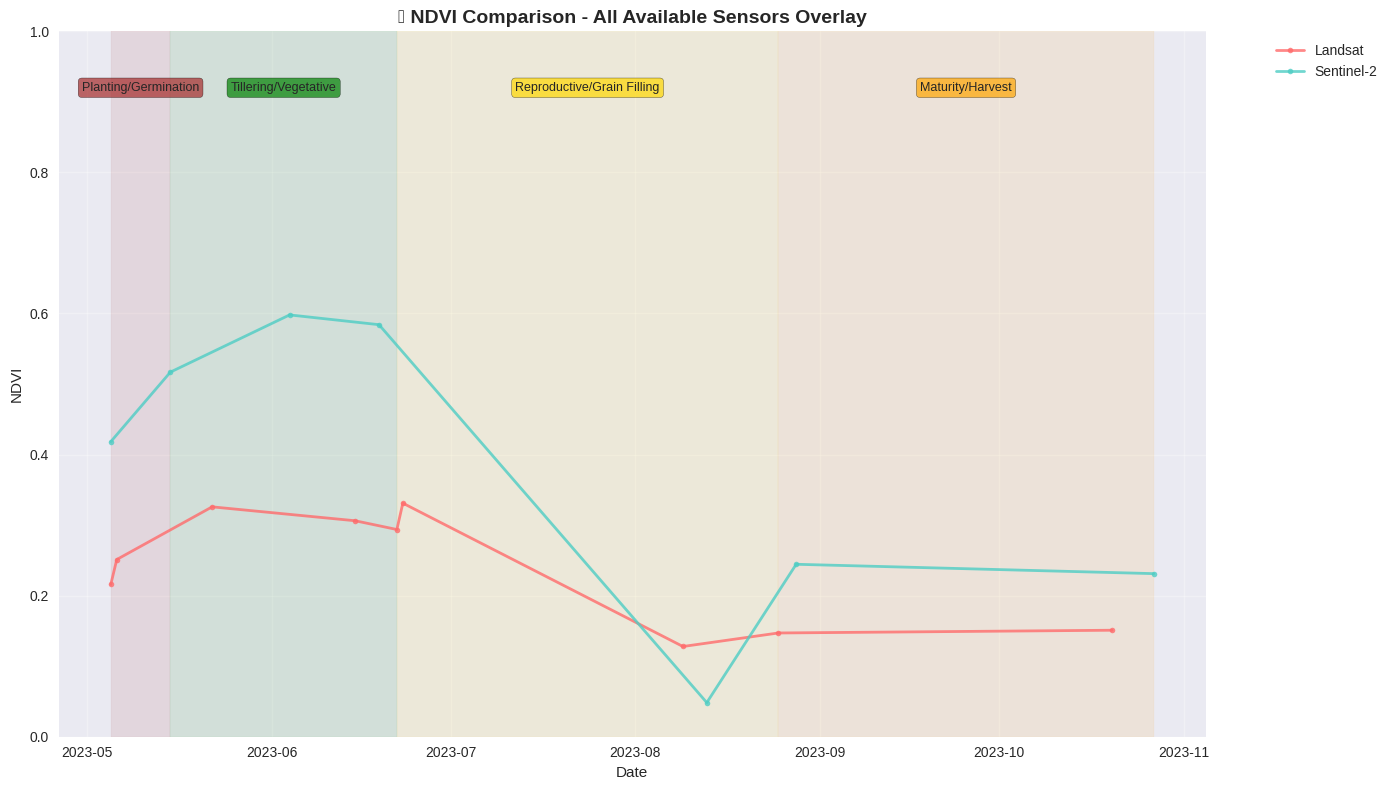

📊 NDVI time series plots created successfully!
🔍 Key observations from the plots will help us understand sensor differences


In [9]:
# Plot NDVI Time Series from Four Sources
def plot_ndvi_comparison(df):
    """Create comprehensive NDVI comparison plots"""

    # Identify available sensor columns in the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]

    # Check if any sensor data is available
    if not sensors:
        print("⚠️ No NDVI data available for plotting.")
        return

    # Dynamically create subplots based on available sensors
    n_sensors = len(sensors)
    n_rows = (n_sensors + 1) // 2
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    fig.suptitle('🌾 NDVI Time Series Comparison', fontsize=16, fontweight='bold')

    # Ensure axes is always a 2D array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)


    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:n_sensors] # Use a subset of colors

    # Individual sensor plots
    for i, (sensor, color) in enumerate(zip(sensors, colors)):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        # Plot NDVI with gaps for clouds
        valid_data = df[['Date', f'{sensor}_NDVI']].dropna()
        ax.plot(valid_data['Date'], valid_data[f'{sensor}_NDVI'],
                'o-', color=color, linewidth=2, markersize=4,
                label=f'{sensor} NDVI', alpha=0.8)

        # Mark cloud gaps
        cloud_gaps = df[df[f'{sensor}_NDVI'].isna()]
        if len(cloud_gaps) > 0:
            ax.scatter(cloud_gaps['Date'], [0.1] * len(cloud_gaps),
                      color='gray', marker='x', s=30, alpha=0.6,
                      label='Cloud gaps')

        # Use datasets_info if available, otherwise just the sensor name
        title_suffix = ""
        if sensor in datasets_info:
             title_suffix = f"\nResolution: {datasets_info[sensor]['spatial_resolution']} / {datasets_info[sensor]['temporal_resolution']}"

        ax.set_title(f'{sensor} NDVI{title_suffix}')
        ax.set_ylabel('NDVI')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_ylim(0, 1)

        # Add phenology phase annotations (assuming a similar pattern)
        # This is a simplified example and might need adjustment based on actual data
        if len(df) > 12: # Only add stages if enough data points
            ax.axvspan(df['Date'].iloc[0], df['Date'].iloc[int(len(df)*0.15)], alpha=0.1, color='brown', label='Germination')
            ax.axvspan(df['Date'].iloc[int(len(df)*0.15)], df['Date'].iloc[int(len(df)*0.5)], alpha=0.1, color='green', label='Vegetative')
            ax.axvspan(df['Date'].iloc[int(len(df)*0.5)], df['Date'].iloc[int(len(df)*0.75)], alpha=0.1, color='gold', label='Reproductive')
            ax.axvspan(df['Date'].iloc[int(len(df)*0.75)], df['Date'].iloc[-1], alpha=0.1, color='orange', label='Maturity')


    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

    # Create overlay comparison plot
    plt.figure(figsize=(14, 8))

    for sensor, color in zip(sensors, colors):
        valid_data = df[['Date', f'{sensor}_NDVI']].dropna()
        plt.plot(valid_data['Date'], valid_data[f'{sensor}_NDVI'],
                'o-', color=color, linewidth=2, markersize=4,
                label=f'{sensor}', alpha=0.8)

    plt.title('🌾 NDVI Comparison - All Available Sensors Overlay',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    # Add rice growth stages
    # This is a simplified example and might need adjustment based on actual data
    if len(df) > 12: # Only add stages if enough data points
        rice_stages = [
            ('Planting/Germination', df['Date'].iloc[0], df['Date'].iloc[int(len(df)*0.15)], 'brown'),
            ('Tillering/Vegetative', df['Date'].iloc[int(len(df)*0.15)], df['Date'].iloc[int(len(df)*0.5)], 'green'),
            ('Reproductive/Grain Filling', df['Date'].iloc[int(len(df)*0.5)], df['Date'].iloc[int(len(df)*0.75)], 'gold'),
            ('Maturity/Harvest', df['Date'].iloc[int(len(df)*0.75)], df['Date'].iloc[-1], 'orange')
        ]

        for stage, start, end, color in rice_stages:
            plt.axvspan(start, end, alpha=0.1, color=color)
            # Adjust text position to avoid overlap
            text_y_position = 0.95 - (sensors.index(sensor) * 0.03) # Offset based on sensor index
            plt.text(start + (end - start) / 2, text_y_position, stage,
                    rotation=0, ha='center', va='center', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7))


    plt.tight_layout()
    plt.show()

# Create the plots
plot_ndvi_comparison(ndvi_data)

print("📊 NDVI time series plots created successfully!")
print("🔍 Key observations from the plots will help us understand sensor differences")

In [11]:
# 📈 NDVI Data Smoothing and Gap Filling

print("Smoothing NDVI Time Series...")
print("=" * 40)

def smooth_ndvi_series(df, window_length=5, polyorder=2):
    """
    Apply Savitzky-Golay filter for smoothing and gap filling.

    Parameters:
    - df: DataFrame with 'Date' and sensor NDVI columns.
    - window_length: The length of the filter window (must be odd).
    - polyorder: The order of the polynomial used to fit the samples.

    Returns:
    - DataFrame with smoothed NDVI columns (NaNs might still exist if window is too small).
    """

    smoothed_df = df.copy()
    sensor_columns = [col for col in df.columns if 'NDVI' in col]

    for col in sensor_columns:
        print(f"   Smoothing {col}...")
        # Interpolate NaNs before smoothing for better results
        interpolated_series = df[col].interpolate(method='linear', limit_direction='both')

        # Apply Savitzky-Golay filter
        # Use try-except in case window_length is larger than data points
        try:
            smoothed_series = savgol_filter(
                interpolated_series,
                window_length=window_length,
                polyorder=polyorder,
                # mode='nearest' # Can use 'nearest' mode if needed
            )
            # Replace original column with smoothed data
            smoothed_df[f'{col}_smoothed'] = smoothed_series
            print(f"      ✅ {col} smoothed successfully.")

        except ValueError as e:
            print(f"      ⚠️ Could not smooth {col}: {e}")
            print(f"         Ensure window_length ({window_length}) is less than the number of data points ({len(interpolated_series)})")
            smoothed_df[f'{col}_smoothed'] = df[col] # Keep original data if smoothing fails

    print("\n✅ Smoothing complete!")
    return smoothed_df

# Apply smoothing to the collected NDVI data
# Adjust window_length and polyorder as needed
smoothed_ndvi_data = smooth_ndvi_series(ndvi_data, window_length=5, polyorder=2)

print("\n📋 Sample of Smoothed Data:")
display(smoothed_ndvi_data.head().round(3))

print("\n📊 Ready for Phenology Extraction using smoothed data!")

Smoothing NDVI Time Series...
   Smoothing Landsat_NDVI...
      ✅ Landsat_NDVI smoothed successfully.
   Smoothing Sentinel-2_NDVI...
      ✅ Sentinel-2_NDVI smoothed successfully.

✅ Smoothing complete!

📋 Sample of Smoothed Data:


Sensor,Date,Landsat_NDVI,Sentinel-2_NDVI,Landsat_NDVI_smoothed,Sentinel-2_NDVI_smoothed
0,2023-05-05,0.216,0.418,0.212,0.418
1,2023-05-06,0.251,NaN,0.258,0.469
2,2023-05-15,NaN,0.517,0.292,0.515
3,2023-05-22,0.326,NaN,0.318,0.562
4,2023-06-04,NaN,0.598,0.320,0.590



📊 Ready for Phenology Extraction using smoothed data!


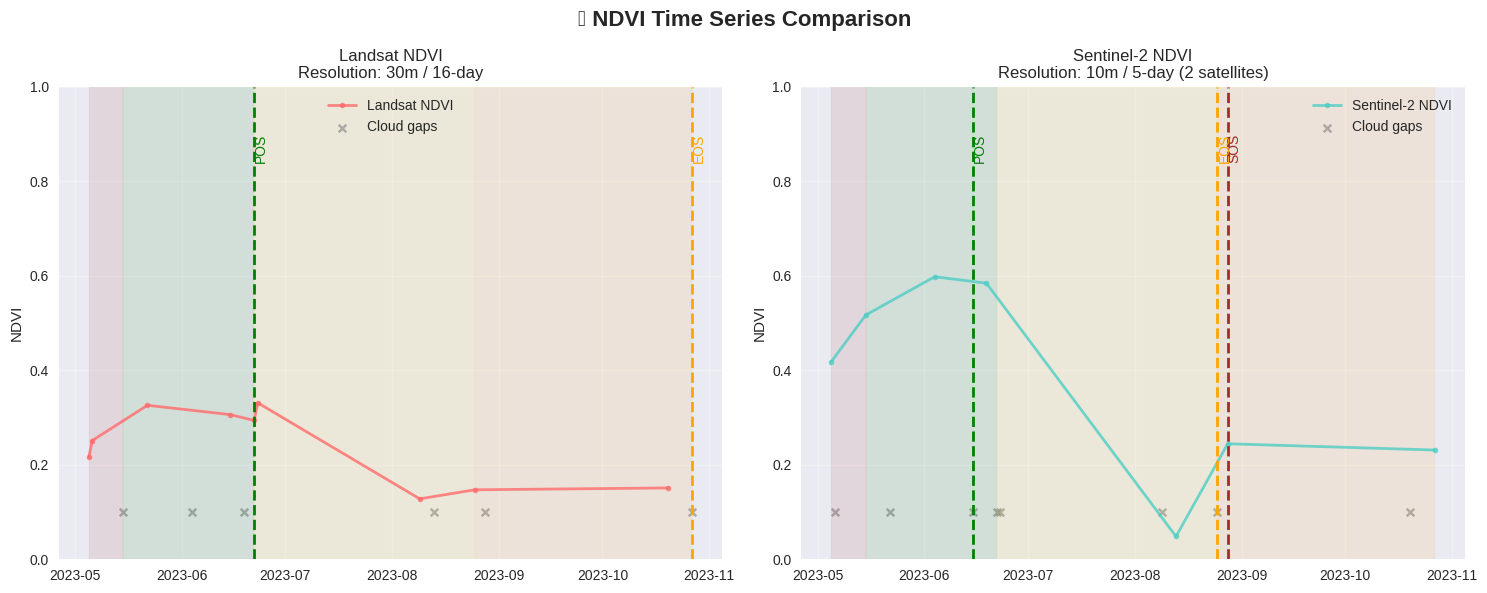

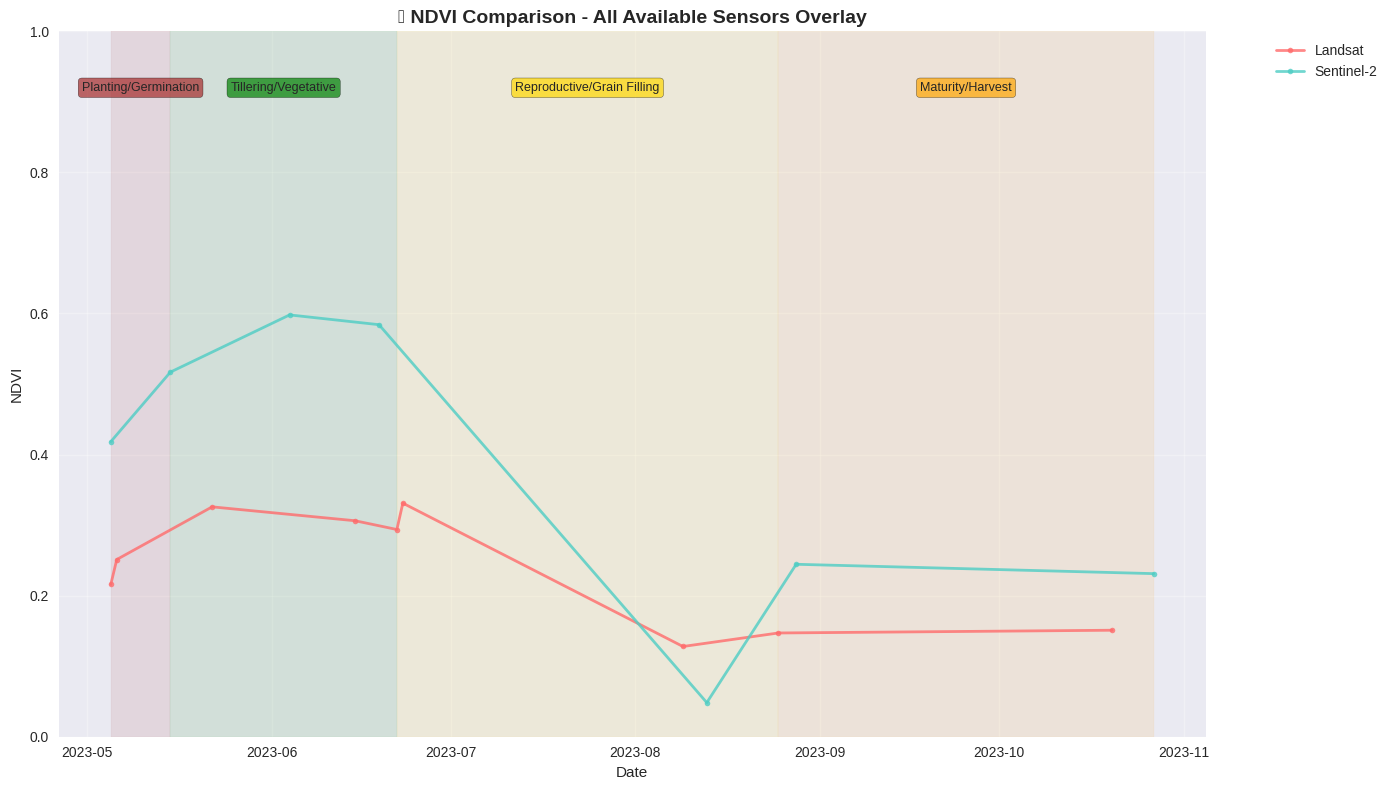

📊 NDVI time series plots with phenology dates created successfully!
🔍 Visualizing phenology dates helps in interpreting growth stages.


In [17]:
# Plot NDVI Time Series from Four Sources
def plot_ndvi_comparison(df, phenology_results=None):
    """Create comprehensive NDVI comparison plots

    Parameters:
    - df: DataFrame with 'Date' and sensor NDVI columns.
    - phenology_results: Dictionary containing phenology dates per sensor (optional).
    """

    # Identify available sensor columns in the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]

    # Check if any sensor data is available
    if not sensors:
        print("⚠️ No NDVI data available for plotting.")
        return

    # Dynamically create subplots based on available sensors
    n_sensors = len(sensors)
    n_rows = (n_sensors + 1) // 2
    n_cols = 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    fig.suptitle('🌾 NDVI Time Series Comparison', fontsize=16, fontweight='bold')

    # Ensure axes is always a 2D array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)


    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:n_sensors] # Use a subset of colors

    # Individual sensor plots
    for i, (sensor, color) in enumerate(zip(sensors, colors)):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        # Plot NDVI with gaps for clouds
        valid_data = df[['Date', f'{sensor}_NDVI']].dropna()
        ax.plot(valid_data['Date'], valid_data[f'{sensor}_NDVI'],
                'o-', color=color, linewidth=2, markersize=4,
                label=f'{sensor} NDVI', alpha=0.8)

        # Mark cloud gaps
        cloud_gaps = df[df[f'{sensor}_NDVI'].isna()]
        if len(cloud_gaps) > 0:
            ax.scatter(cloud_gaps['Date'], [0.1] * len(cloud_gaps),
                      color='gray', marker='x', s=30, alpha=0.6,
                      label='Cloud gaps')

        # Use datasets_info if available, otherwise just the sensor name
        title_suffix = ""
        if sensor in datasets_info:
             title_suffix = f"\nResolution: {datasets_info[sensor]['spatial_resolution']} / {datasets_info[sensor]['temporal_resolution']}"

        ax.set_title(f'{sensor} NDVI{title_suffix}')
        ax.set_ylabel('NDVI')
        ax.grid(True, alpha=0.3)
        ax.legend()
        ax.set_ylim(0, 1)

        # Add phenology phase annotations (assuming a similar pattern)
        # This is a simplified example and might need adjustment based on actual data
        if len(df) > 12: # Only add stages if enough data points
            ax.axvspan(df['Date'].iloc[0], df['Date'].iloc[int(len(df)*0.15)], alpha=0.1, color='brown', label='Germination')
            ax.axvspan(df['Date'].iloc[int(len(df)*0.15)], df['Date'].iloc[int(len(df)*0.5)], alpha=0.1, color='green', label='Vegetative')
            ax.axvspan(df['Date'].iloc[int(len(df)*0.5)], df['Date'].iloc[int(len(df)*0.75)], alpha=0.1, color='gold', label='Reproductive')
            ax.axvspan(df['Date'].iloc[int(len(df)*0.75)], df['Date'].iloc[-1], alpha=0.1, color='orange', label='Maturity')

        # Add extracted phenology dates if available
        if phenology_results and sensor in phenology_results:
            dates = phenology_results[sensor]
            if 'SOS' in dates:
                ax.axvline(dates['SOS'], color='brown', linestyle='--', linewidth=2, label='SOS')
                ax.text(dates['SOS'], ax.get_ylim()[1] * 0.9, 'SOS', rotation=90, va='top', color='brown')
            if 'POS' in dates:
                ax.axvline(dates['POS'], color='green', linestyle='--', linewidth=2, label='POS')
                ax.text(dates['POS'], ax.get_ylim()[1] * 0.9, 'POS', rotation=90, va='top', color='green')
            if 'EOS' in dates:
                ax.axvline(dates['EOS'], color='orange', linestyle='--', linewidth=2, label='EOS')
                ax.text(dates['EOS'], ax.get_ylim()[1] * 0.9, 'EOS', rotation=90, va='top', color='orange')


    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

    # Create overlay comparison plot
    plt.figure(figsize=(14, 8))

    for sensor, color in zip(sensors, colors):
        valid_data = df[['Date', f'{sensor}_NDVI']].dropna()
        plt.plot(valid_data['Date'], valid_data[f'{sensor}_NDVI'],
                'o-', color=color, linewidth=2, markersize=4,
                label=f'{sensor}', alpha=0.8)

    plt.title('🌾 NDVI Comparison - All Available Sensors Overlay',
              fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('NDVI')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

    # Add rice growth stages
    # This is a simplified example and might need adjustment based on actual data
    if len(df) > 12: # Only add stages if enough data points
        rice_stages = [
            ('Planting/Germination', df['Date'].iloc[0], df['Date'].iloc[int(len(df)*0.15)], 'brown'),
            ('Tillering/Vegetative', df['Date'].iloc[int(len(df)*0.15)], df['Date'].iloc[int(len(df)*0.5)], 'green'),
            ('Reproductive/Grain Filling', df['Date'].iloc[int(len(df)*0.5)], df['Date'].iloc[int(len(df)*0.75)], 'gold'),
            ('Maturity/Harvest', df['Date'].iloc[int(len(df)*0.75)], df['Date'].iloc[-1], 'orange')
        ]

        for stage, start, end, color in rice_stages:
            plt.axvspan(start, end, alpha=0.1, color=color)
            # Adjust text position to avoid overlap
            text_y_position = 0.95 - (sensors.index(sensor) * 0.03) # Offset based on sensor index
            plt.text(start + (end - start) / 2, text_y_position, stage,
                    rotation=0, ha='center', va='center', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7))


    plt.tight_layout()
    plt.show()

# Create the plots with phenology results
plot_ndvi_comparison(ndvi_data, phenology_results)

print("📊 NDVI time series plots with phenology dates created successfully!")
print("🔍 Visualizing phenology dates helps in interpreting growth stages.")

🔄 NDVI SOURCE AGREEMENT ANALYSIS

📊 PAIRWISE AGREEMENT STATISTICS:
----------------------------------------
No pairwise agreement statistics could be calculated (possibly due to insufficient common data points).


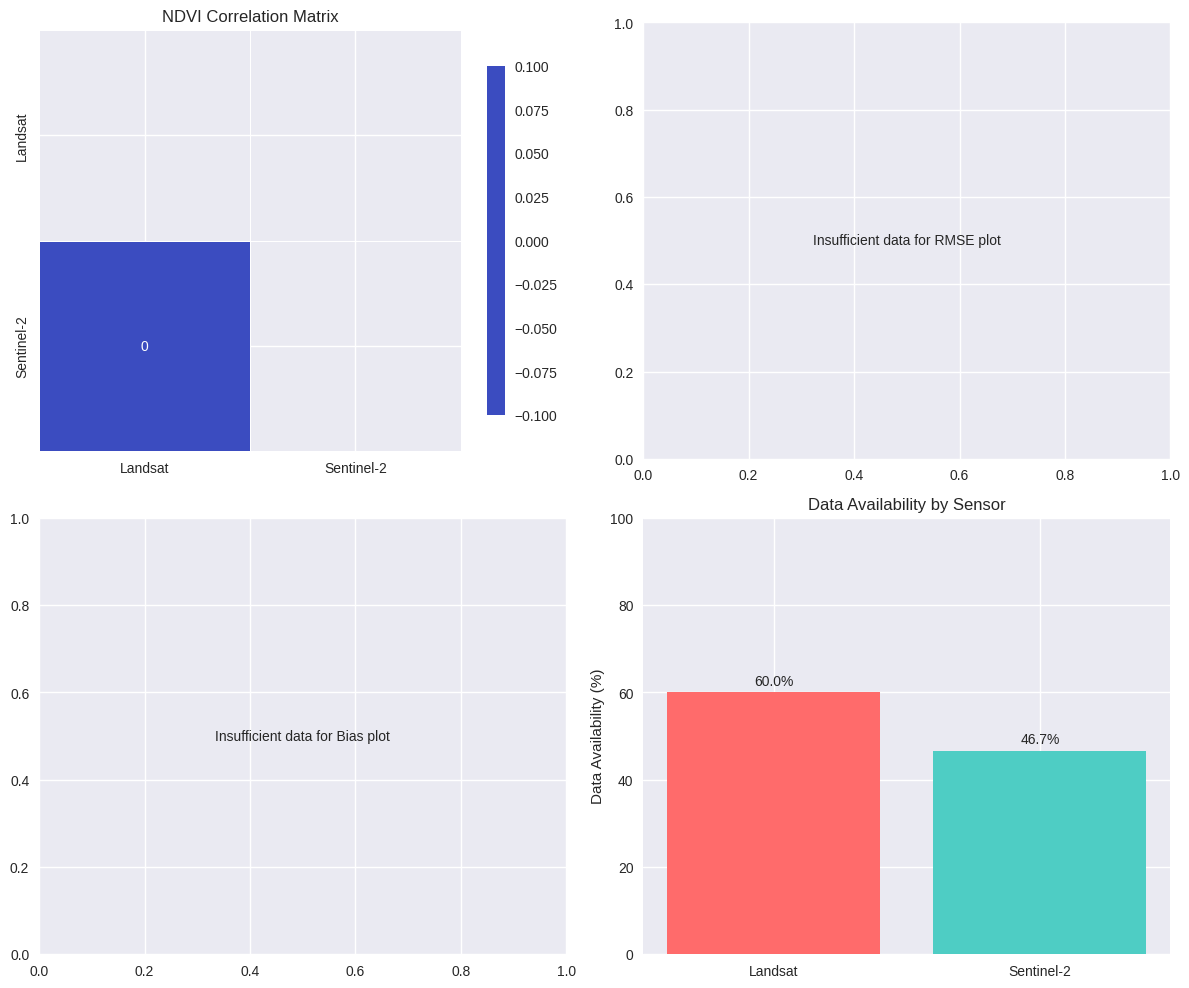


✅ Source agreement analysis completed!
🎯 This analysis helps identify which sensors agree best for crop monitoring


In [19]:
# Source Agreement Analysis
def analyze_source_agreement(df):
    """Analyze agreement between different NDVI sources"""

    # Dynamically get available sensor columns from the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]

    if len(sensors) < 2:
        print("⚠️ Not enough sensor data available for agreement analysis (need at least 2 sensors).")
        return None, None

    # Create agreement statistics
    agreement_stats = {}

    print("🔄 NDVI SOURCE AGREEMENT ANALYSIS")
    print("=" * 60)

    # Calculate pairwise correlations
    # Use available sensors for the matrix size
    correlation_matrix = np.zeros((len(sensors), len(sensors)))
    # Create a mapping from sensor name to its index in the 'sensors' list
    sensor_to_index = {sensor: i for i, sensor in enumerate(sensors)}


    for i, sensor1 in enumerate(sensors):
        for j, sensor2 in enumerate(sensors):
            if i != j:
                # Find common valid dates
                common_data = df[['Date', f'{sensor1}_NDVI', f'{sensor2}_NDVI']].dropna()
                if len(common_data) > 3: # Need at least 4 points for meaningful correlation
                    correlation = common_data[f'{sensor1}_NDVI'].corr(common_data[f'{sensor2}_NDVI'])
                    correlation_matrix[i, j] = correlation

                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(common_data[f'{sensor1}_NDVI'],
                                                    common_data[f'{sensor2}_NDVI']))

                    # Calculate bias
                    bias = np.mean(common_data[f'{sensor1}_NDVI'] - common_data[f'{sensor2}_NDVI'])

                    agreement_stats[f'{sensor1}_vs_{sensor2}'] = {
                        'correlation': correlation,
                        'rmse': rmse,
                        'bias': bias,
                        'n_points': len(common_data)
                    }
            else:
                correlation_matrix[i, j] = 1.0

    # Display agreement statistics
    print("\n📊 PAIRWISE AGREEMENT STATISTICS:")
    print("-" * 40)

    if not agreement_stats:
        print("No pairwise agreement statistics could be calculated (possibly due to insufficient common data points).")
    else:
        for comparison, stats in agreement_stats.items():
            sensor1, sensor2 = comparison.split('_vs_')
            print(f"\n🔸 {sensor1} vs {sensor2}:")
            print(f"   Correlation (r): {stats['correlation']:.3f}")
            print(f"   RMSE: {stats['rmse']:.3f}")
            print(f"   Bias: {stats['bias']:.3f}")
            print(f"   Data points: {stats['n_points']}")

            # Interpretation
            if stats['correlation'] > 0.9:
                agreement = "Excellent"
            elif stats['correlation'] > 0.8:
                agreement = "Very Good"
            elif stats['correlation'] > 0.7:
                agreement = "Good"
            elif stats['correlation'] > 0.6:
                agreement = "Fair"
            else:
                agreement = "Poor"
            print(f"   Agreement: {agreement}")

    # Create correlation heatmap
    plt.figure(figsize=(12, 10)) # Adjusted figure size

    # Correlation heatmap
    plt.subplot(2, 2, 1)
    # Ensure the mask size matches the correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                xticklabels=sensors, yticklabels=sensors, mask=mask,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('NDVI Correlation Matrix')

    # RMSE comparison
    plt.subplot(2, 2, 2)
    if agreement_stats:
        rmse_values = [stats['rmse'] for stats in agreement_stats.values()]
        comparison_names = [key.replace('_vs_', ' vs ') for key in agreement_stats.keys()]
        plt.bar(range(len(rmse_values)), rmse_values, color='lightcoral')
        plt.xticks(range(len(rmse_values)), comparison_names, rotation=45, ha='right')
        plt.ylabel('RMSE')
        plt.title('RMSE Between Sensors')
    else:
        plt.text(0.5, 0.5, "Insufficient data for RMSE plot", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


    # Bias comparison
    plt.subplot(2, 2, 3)
    if agreement_stats:
        bias_values = [stats['bias'] for stats in agreement_stats.values()]
        colors = ['red' if x < 0 else 'blue' for x in bias_values]
        plt.bar(range(len(bias_values)), bias_values, color=colors, alpha=0.7)
        plt.xticks(range(len(bias_values)), comparison_names, rotation=45, ha='right')
        plt.ylabel('Bias (NDVI units)')
        plt.title('Bias Between Sensors')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    else:
         plt.text(0.5, 0.5, "Insufficient data for Bias plot", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


    # Data availability comparison
    plt.subplot(2, 2, 4)
    availability = []
    for sensor_col in sensor_columns: # Iterate through actual columns
        valid_points = df[sensor_col].count()
        total_points = len(df)
        availability.append(valid_points / total_points * 100 if total_points > 0 else 0)

    plt.bar([col.replace('_NDVI', '') for col in sensor_columns], availability, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(sensor_columns)]) # Use subset of colors based on available sensors
    plt.ylabel('Data Availability (%)')
    plt.title('Data Availability by Sensor')
    plt.ylim(0, 100)

    for i, v in enumerate(availability):
        plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return agreement_stats, correlation_matrix

# Perform agreement analysis
agreement_results, corr_matrix = analyze_source_agreement(ndvi_data)

print("\n✅ Source agreement analysis completed!")
print("🎯 This analysis helps identify which sensors agree best for crop monitoring")

🌱 START OF SEASON (SOS) DETECTION


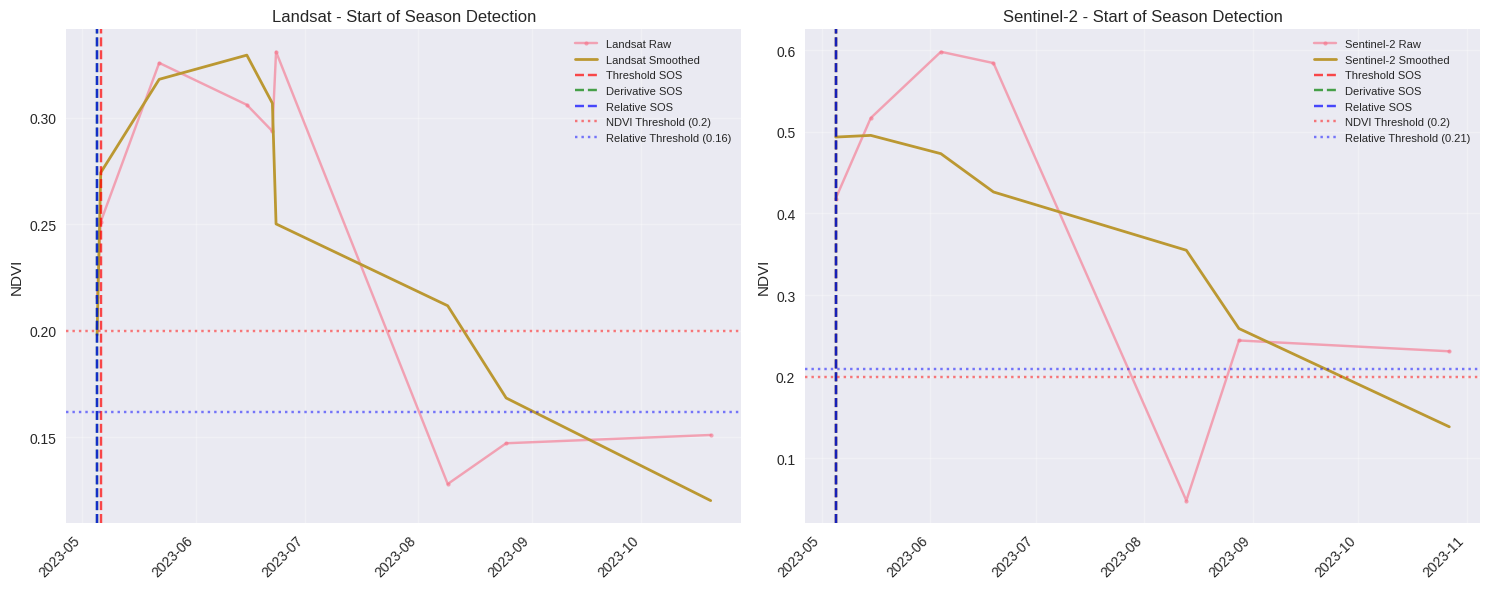


📋 START OF SEASON DETECTION RESULTS:
----------------------------------------------------------------------
Sensor       Threshold SOS   Derivative SOS  Relative SOS   
----------------------------------------------------------------------
Landsat      2023-05-06      2023-05-05      2023-05-05     
Sentinel-2   2023-05-05      2023-05-05      2023-05-05     

✅ Start of Season detection completed!
🌱 SOS timing is crucial for STICS model initialization


In [21]:
# Phenology Detection: Start of Season (SOS)
def detect_start_of_season(df, threshold_method='derivative', min_ndvi=0.2):
    """
    Detect Start of Season (SOS) for each sensor

    Methods:
    - 'threshold': When NDVI first exceeds a threshold
    - 'derivative': When NDVI growth rate exceeds threshold
    - 'relative': When NDVI reaches percentage of annual amplitude
    """

    # Dynamically get available sensor columns from the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]


    sos_results = {}

    print("🌱 START OF SEASON (SOS) DETECTION")
    print("=" * 50)

    # Dynamically create subplots based on available sensors
    n_sensors = len(sensors)
    n_rows = (n_sensors + 1) // 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))

    # Ensure axes is always a 2D array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)


    for i, sensor in enumerate(sensors):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        # Get valid data
        sensor_data = df[['Date', f'{sensor}_NDVI']].dropna().reset_index(drop=True)

        if len(sensor_data) < 5:
            print(f"⚠️ {sensor}: Insufficient data for SOS detection")
            continue

        dates = sensor_data['Date']
        ndvi = sensor_data[f'{sensor}_NDVI']

        # Smooth the data to reduce noise
        if len(ndvi) > 5:
            # Ensure window_length is odd and less than data points
            window = min(7, len(ndvi)//2*2+1)
            if window < 3: # Ensure a minimum window size for smoothing
                window = 3
            ndvi_smooth = savgol_filter(ndvi, window, 2)
        else:
            ndvi_smooth = ndvi.values

        # Method 1: Threshold-based (NDVI > min_ndvi)
        threshold_sos = None
        for j, ndvi_val in enumerate(ndvi_smooth):
            if ndvi_val > min_ndvi:
                threshold_sos = dates.iloc[j]
                break

        # Method 2: Derivative-based (maximum growth rate)
        if len(ndvi_smooth) > 3:
            derivatives = np.gradient(ndvi_smooth)
            max_derivative_idx = np.argmax(derivatives)
            derivative_sos = dates.iloc[max_derivative_idx]
        else:
            derivative_sos = None

        # Method 3: Relative threshold (20% of seasonal amplitude)
        ndvi_min = np.min(ndvi_smooth)
        ndvi_max = np.max(ndvi_smooth)
        relative_threshold = ndvi_min + 0.2 * (ndvi_max - ndvi_min)

        relative_sos = None
        for j, ndvi_val in enumerate(ndvi_smooth):
            if ndvi_val > relative_threshold:
                relative_sos = dates.iloc[j]
                break

        # Store results
        sos_results[sensor] = {
            'threshold_sos': threshold_sos,
            'derivative_sos': derivative_sos,
            'relative_sos': relative_sos,
            'ndvi_at_sos': ndvi_smooth[0] if threshold_sos else None # Placeholder, needs refinement
        }

        # Plot results
        ax.plot(dates, ndvi, 'o-', alpha=0.6, label=f'{sensor} Raw', markersize=3)
        ax.plot(dates, ndvi_smooth, '-', linewidth=2, label=f'{sensor} Smoothed')

        # Mark different SOS detections
        if threshold_sos:
            ax.axvline(threshold_sos, color='red', linestyle='--', alpha=0.7,
                       label=f'Threshold SOS')
        if derivative_sos:
            ax.axvline(derivative_sos, color='green', linestyle='--', alpha=0.7,
                       label=f'Derivative SOS')
        if relative_sos:
            ax.axvline(relative_sos, color='blue', linestyle='--', alpha=0.7,
                       label=f'Relative SOS')

        # Add horizontal threshold line
        ax.axhline(min_ndvi, color='red', linestyle=':', alpha=0.5,
                   label=f'NDVI Threshold ({min_ndvi})')
        ax.axhline(relative_threshold, color='blue', linestyle=':', alpha=0.5,
                   label=f'Relative Threshold ({relative_threshold:.2f})')

        ax.set_title(f'{sensor} - Start of Season Detection')
        ax.set_ylabel('NDVI')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels

    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n📋 START OF SEASON DETECTION RESULTS:")
    print("-" * 70)
    print(f"{'Sensor':<12} {'Threshold SOS':<15} {'Derivative SOS':<15} {'Relative SOS':<15}")
    print("-" * 70)

    for sensor, results in sos_results.items():
        threshold_str = results['threshold_sos'].strftime('%Y-%m-%d') if results['threshold_sos'] else 'N/A'
        derivative_str = results['derivative_sos'].strftime('%Y-%m-%d') if results['derivative_sos'] else 'N/A'
        relative_str = results['relative_sos'].strftime('%Y-%m-%d') if results['relative_sos'] else 'N/A'

        print(f"{sensor:<12} {threshold_str:<15} {derivative_str:<15} {relative_str:<15}")

    return sos_results

# Detect Start of Season
sos_detection = detect_start_of_season(ndvi_data)

print("\n✅ Start of Season detection completed!")
print("🌱 SOS timing is crucial for STICS model initialization")

🍂 END OF SEASON (EOS) DETECTION


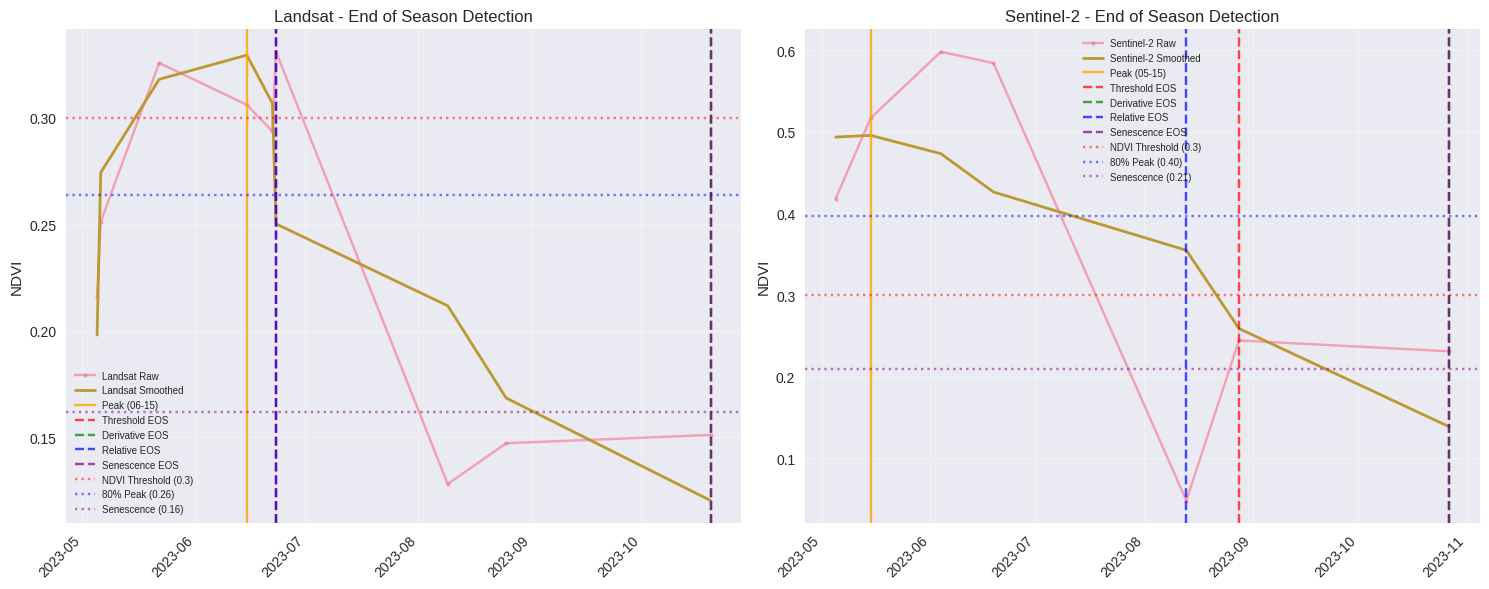


📋 END OF SEASON DETECTION RESULTS:
-------------------------------------------------------------------------------------
Sensor       Peak Date    Threshold EOS   Derivative EOS  Relative EOS   
-------------------------------------------------------------------------------------
Landsat      2023-06-15   2023-06-23      2023-10-20      2023-06-23     
Sentinel-2   2023-05-15   2023-08-28      2023-10-27      2023-08-13     

✅ End of Season detection completed!
🍂 EOS timing helps define harvest dates and total growing period


In [23]:
# Phenology Detection: End of Season (EOS)
def detect_end_of_season(df, threshold_method='derivative', min_ndvi=0.3):
    """
    Detect End of Season (EOS) for each sensor

    Methods:
    - 'threshold': When NDVI drops below threshold after peak
    - 'derivative': When NDVI decline rate exceeds threshold
    - 'relative': When NDVI drops to percentage of peak value
    """

    # Dynamically get available sensor columns from the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]

    eos_results = {}

    print("🍂 END OF SEASON (EOS) DETECTION")
    print("=" * 50)

    # Dynamically create subplots based on available sensors
    n_sensors = len(sensors)
    n_rows = (n_sensors + 1) // 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))

    # Ensure axes is always a 2D array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)

    for i, sensor in enumerate(sensors):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        # Get valid data
        sensor_data = df[['Date', f'{sensor}_NDVI']].dropna().reset_index(drop=True)

        if len(sensor_data) < 5:
            print(f"⚠️ {sensor}: Insufficient data for EOS detection")
            continue

        dates = sensor_data['Date']
        ndvi = sensor_data[f'{sensor}_NDVI']

        # Smooth the data
        if len(ndvi) > 5:
            ndvi_smooth = savgol_filter(ndvi, min(7, len(ndvi)//2*2+1), 2)
        else:
            ndvi_smooth = ndvi.values

        # Find peak NDVI (needed for EOS detection)
        peak_idx = np.argmax(ndvi_smooth)
        peak_date = dates.iloc[peak_idx]
        peak_ndvi = ndvi_smooth[peak_idx]

        # Only look for EOS after the peak
        post_peak_data = ndvi_smooth[peak_idx:]
        post_peak_dates = dates.iloc[peak_idx:]

        # Method 1: Threshold-based (NDVI < min_ndvi after peak)
        threshold_eos = None
        for j, ndvi_val in enumerate(post_peak_data):
            if ndvi_val < min_ndvi:
                threshold_eos = post_peak_dates.iloc[j]
                break

        # Method 2: Derivative-based (maximum decline rate after peak)
        if len(post_peak_data) > 3:
            derivatives = np.gradient(post_peak_data)
            # Find most negative derivative (steepest decline)
            min_derivative_idx = np.argmin(derivatives)
            derivative_eos = post_peak_dates.iloc[min_derivative_idx]
        else:
            derivative_eos = None

        # Method 3: Relative threshold (drops to 80% of peak value)
        relative_threshold = peak_ndvi * 0.8

        relative_eos = None
        for j, ndvi_val in enumerate(post_peak_data):
            if ndvi_val < relative_threshold:
                relative_eos = post_peak_dates.iloc[j]
                break

        # Method 4: End of season when NDVI drops to 20% above minimum
        ndvi_min = np.min(ndvi_smooth)
        senescence_threshold = ndvi_min + 0.2 * (peak_ndvi - ndvi_min)

        senescence_eos = None
        for j, ndvi_val in enumerate(post_peak_data):
            if ndvi_val < senescence_threshold:
                senescence_eos = post_peak_dates.iloc[j]
                break


        # Store results
        eos_results[sensor] = {
            'threshold_eos': threshold_eos,
            'derivative_eos': derivative_eos,
            'relative_eos': relative_eos,
            'senescence_eos': senescence_eos,
            'peak_date': peak_date,
            'peak_ndvi': peak_ndvi
        }

        # Plot results
        ax.plot(dates, ndvi, 'o-', alpha=0.6, label=f'{sensor} Raw', markersize=3)
        ax.plot(dates, ndvi_smooth, '-', linewidth=2, label=f'{sensor} Smoothed')

        # Mark peak
        ax.axvline(peak_date, color='orange', linestyle='-', alpha=0.8,
                   label=f'Peak ({peak_date.strftime("%m-%d")})')

        # Mark different EOS detections
        if threshold_eos:
            ax.axvline(threshold_eos, color='red', linestyle='--', alpha=0.7,
                       label=f'Threshold EOS')
        if derivative_eos:
            ax.axvline(derivative_eos, color='green', linestyle='--', alpha=0.7,
                       label=f'Derivative EOS')
        if relative_eos:
            ax.axvline(relative_eos, color='blue', linestyle='--', alpha=0.7,
                       label=f'Relative EOS')
        if senescence_eos:
            ax.axvline(senescence_eos, color='purple', linestyle='--', alpha=0.7,
                       label=f'Senescence EOS')


        # Add horizontal threshold lines
        ax.axhline(min_ndvi, color='red', linestyle=':', alpha=0.5,
                   label=f'NDVI Threshold ({min_ndvi})')
        ax.axhline(relative_threshold, color='blue', linestyle=':', alpha=0.5,
                   label=f'80% Peak ({relative_threshold:.2f})')
        ax.axhline(senescence_threshold, color='purple', linestyle=':', alpha=0.5,
                   label=f'Senescence ({senescence_threshold:.2f})')


        ax.set_title(f'{sensor} - End of Season Detection')
        ax.set_ylabel('NDVI')
        ax.legend(fontsize=7)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels

    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n📋 END OF SEASON DETECTION RESULTS:")
    print("-" * 85)
    print(f"{'Sensor':<12} {'Peak Date':<12} {'Threshold EOS':<15} {'Derivative EOS':<15} {'Relative EOS':<15}")
    print("-" * 85)

    for sensor, results in eos_results.items():
        peak_str = results['peak_date'].strftime('%Y-%m-%d') if results['peak_date'] else 'N/A'
        threshold_str = results['threshold_eos'].strftime('%Y-%m-%d') if results['threshold_eos'] else 'N/A'
        derivative_str = results['derivative_eos'].strftime('%Y-%m-%d') if results['derivative_eos'] else 'N/A'
        relative_str = results['relative_eos'].strftime('%Y-%m-%d') if results['relative_eos'] else 'N/A'

        print(f"{sensor:<12} {peak_str:<12} {threshold_str:<15} {derivative_str:<15} {relative_str:<15}")

    return eos_results

# Detect End of Season
eos_detection = detect_end_of_season(ndvi_data)

print("\n✅ End of Season detection completed!")
print("🍂 EOS timing helps define harvest dates and total growing period")

📏 GROWING SEASON LENGTH ANALYSIS

🔸 SENTINEL-2 GROWING SEASON LENGTHS:
----------------------------------------
   Threshold Method:
      SOS: 2023-05-05
      EOS: 2023-08-28
      Length: 115 days
   Derivative Method:
      SOS: 2023-05-05
      EOS: 2023-10-27
      Length: 175 days
   Relative Method:
      SOS: 2023-05-05
      EOS: 2023-08-13
      Length: 100 days
   Threshold-Senescence:
      SOS: 2023-05-05
      EOS: 2023-10-27
      Length: 175 days

🔸 LANDSAT GROWING SEASON LENGTHS:
----------------------------------------
   Threshold Method:
      SOS: 2023-05-06
      EOS: 2023-06-23
      Length: 48 days
   Derivative Method:
      SOS: 2023-05-05
      EOS: 2023-10-20
      Length: 168 days
   Relative Method:
      SOS: 2023-05-05
      EOS: 2023-06-23
      Length: 49 days
   Threshold-Senescence:
      SOS: 2023-05-06
      EOS: 2023-10-20
      Length: 167 days


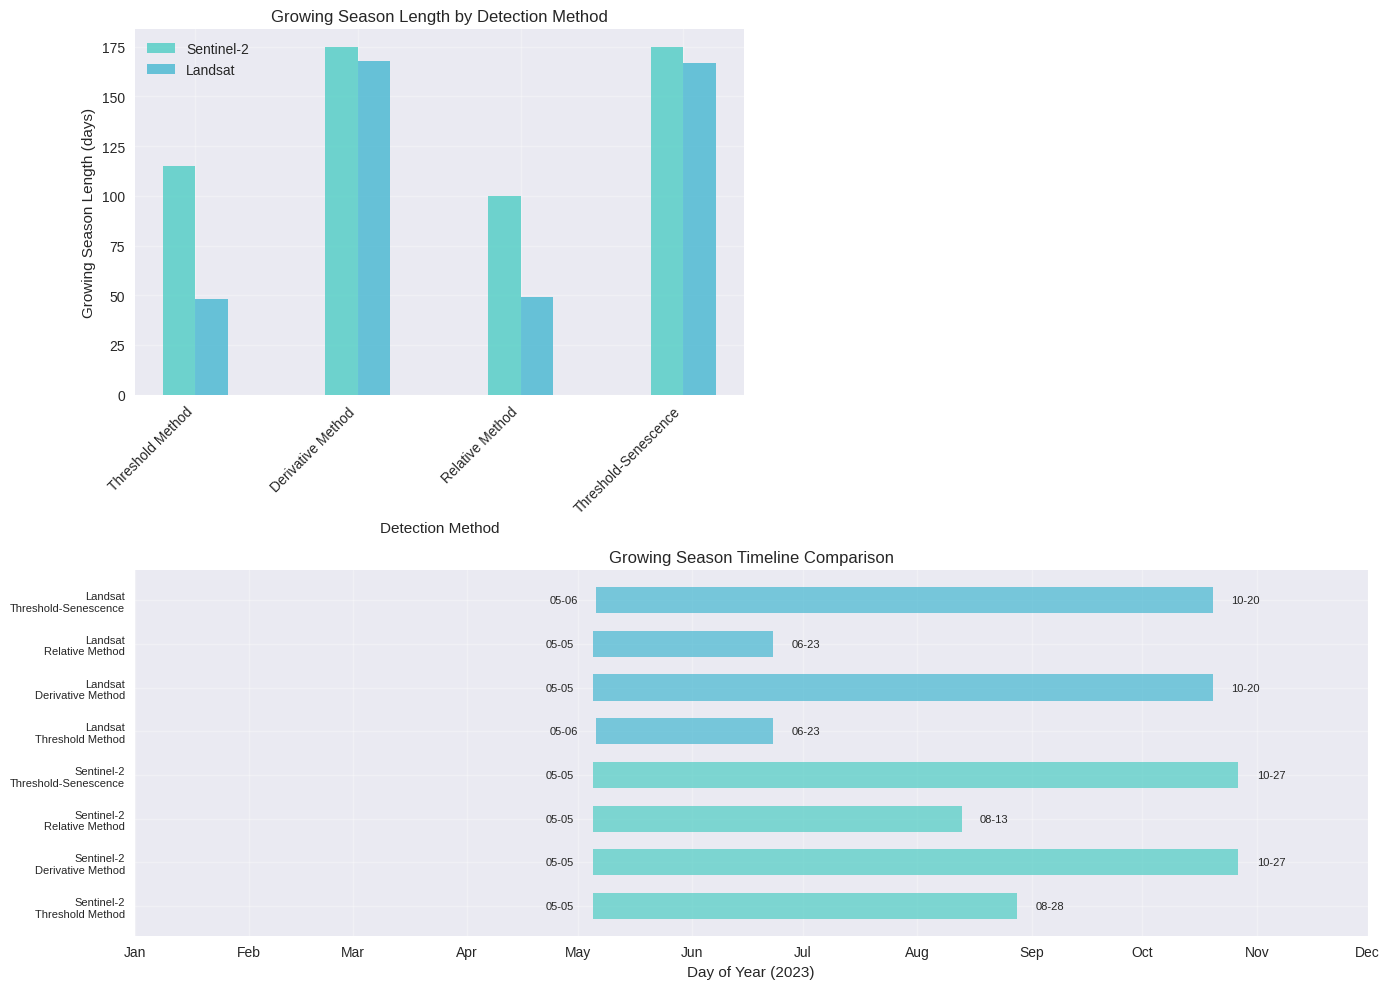


📊 GROWING SEASON LENGTH STATISTICS:
--------------------------------------------------
Mean season length: 124.6 ± 51.3 days
Range: 48 - 175 days
Coefficient of variation: 41.2%

✅ Growing season length analysis completed!
📏 Season length is essential for STICS crop cycle parameterization


In [24]:
# Calculate Growing Season Length
def calculate_growing_season_length(sos_results, eos_results):
    """
    Calculate growing season length using different SOS/EOS detection methods
    """

    sensors = ['MODIS', 'Sentinel-2', 'Landsat', 'VIIRS']
    season_lengths = {}

    print("📏 GROWING SEASON LENGTH ANALYSIS")
    print("=" * 60)

    # Define method combinations for season length calculation
    method_combinations = [
        ('threshold_sos', 'threshold_eos', 'Threshold Method'),
        ('derivative_sos', 'derivative_eos', 'Derivative Method'),
        ('relative_sos', 'relative_eos', 'Relative Method'),
        ('threshold_sos', 'senescence_eos', 'Threshold-Senescence'),
    ]

    for sensor in sensors:
        if sensor not in sos_results or sensor not in eos_results:
            continue

        season_lengths[sensor] = {}

        print(f"\n🔸 {sensor.upper()} GROWING SEASON LENGTHS:")
        print("-" * 40)

        for sos_method, eos_method, method_name in method_combinations:
            sos_date = sos_results[sensor].get(sos_method)
            eos_date = eos_results[sensor].get(eos_method)

            if sos_date and eos_date and eos_date > sos_date:
                season_length = (eos_date - sos_date).days
                season_lengths[sensor][method_name] = {
                    'sos_date': sos_date,
                    'eos_date': eos_date,
                    'length_days': season_length
                }

                print(f"   {method_name}:")
                print(f"      SOS: {sos_date.strftime('%Y-%m-%d')}")
                print(f"      EOS: {eos_date.strftime('%Y-%m-%d')}")
                print(f"      Length: {season_length} days")
            else:
                print(f"   {method_name}: Unable to calculate (missing dates)")

    # Create comparison visualization
    plt.figure(figsize=(14, 10))

    # Subplot 1: Season length comparison by method
    plt.subplot(2, 2, 1)
    method_names = [combo[2] for combo in method_combinations]
    sensor_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    x_pos = np.arange(len(method_names))
    width = 0.2

    for i, sensor in enumerate(sensors):
        if sensor in season_lengths:
            lengths = []
            for method_name in method_names:
                if method_name in season_lengths[sensor]:
                    lengths.append(season_lengths[sensor][method_name]['length_days'])
                else:
                    lengths.append(0)

            plt.bar(x_pos + i * width, lengths, width,
                   label=sensor, color=sensor_colors[i], alpha=0.8)

    plt.xlabel('Detection Method')
    plt.ylabel('Growing Season Length (days)')
    plt.title('Growing Season Length by Detection Method')
    plt.xticks(x_pos + width * 1.5, method_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Timeline visualization
    plt.subplot(2, 1, 2)

    y_positions = []
    y_labels = []

    for i, sensor in enumerate(sensors):
        if sensor in season_lengths:
            for j, method_name in enumerate(method_names):
                if method_name in season_lengths[sensor]:
                    data = season_lengths[sensor][method_name]
                    y_pos = i * len(method_names) + j
                    y_positions.append(y_pos)
                    y_labels.append(f"{sensor}\n{method_name}")

                    # Plot season timeline
                    plt.barh(y_pos, data['length_days'],
                            left=(data['sos_date'] - pd.Timestamp('2023-01-01')).days,
                            height=0.6, color=sensor_colors[i], alpha=0.7)

                    # Add text annotations
                    plt.text((data['sos_date'] - pd.Timestamp('2023-01-01')).days - 5,
                            y_pos, data['sos_date'].strftime('%m-%d'),
                            ha='right', va='center', fontsize=8)
                    plt.text((data['eos_date'] - pd.Timestamp('2023-01-01')).days + 5,
                            y_pos, data['eos_date'].strftime('%m-%d'),
                            ha='left', va='center', fontsize=8)

    plt.yticks(y_positions, y_labels, fontsize=8)
    plt.xlabel('Day of Year (2023)')
    plt.title('Growing Season Timeline Comparison')
    plt.grid(True, alpha=0.3)

    # Add month markers
    month_starts = [pd.Timestamp(f'2023-{m:02d}-01') for m in range(1, 13)]
    month_days = [(date - pd.Timestamp('2023-01-01')).days for date in month_starts]
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    plt.xticks(month_days, month_names)

    plt.tight_layout()
    plt.show()

    # Statistical summary
    print(f"\n📊 GROWING SEASON LENGTH STATISTICS:")
    print("-" * 50)

    all_lengths = []
    for sensor in sensors:
        if sensor in season_lengths:
            for method_name in method_names:
                if method_name in season_lengths[sensor]:
                    all_lengths.append(season_lengths[sensor][method_name]['length_days'])

    if all_lengths:
        print(f"Mean season length: {np.mean(all_lengths):.1f} ± {np.std(all_lengths):.1f} days")
        print(f"Range: {np.min(all_lengths)} - {np.max(all_lengths)} days")
        print(f"Coefficient of variation: {np.std(all_lengths)/np.mean(all_lengths)*100:.1f}%")

    return season_lengths

# Calculate growing season lengths
growing_seasons = calculate_growing_season_length(sos_detection, eos_detection)

print("\n✅ Growing season length analysis completed!")
print("📏 Season length is essential for STICS crop cycle parameterization")

🌟 PEAK GROWTH PERIOD ANALYSIS


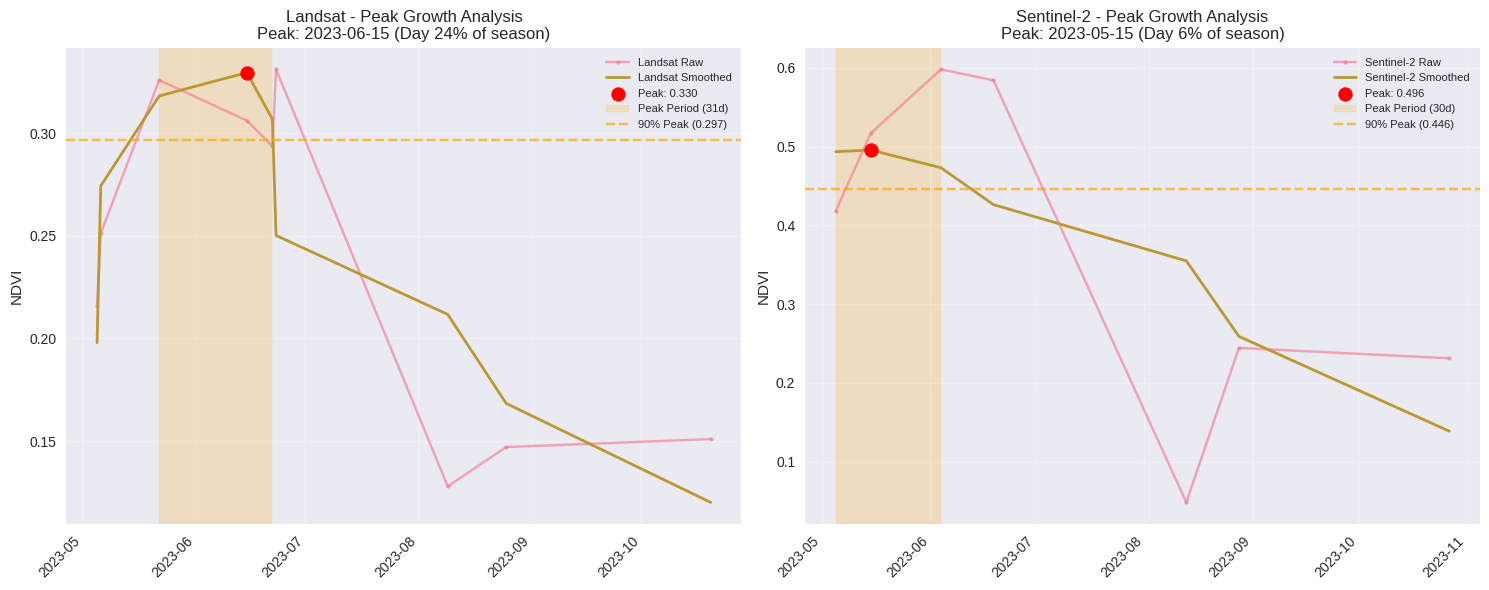


📋 PEAK GROWTH CHARACTERISTICS:
--------------------------------------------------------------------------------
Sensor       Peak Date    Peak NDVI  Duration   Timing %   Amplitude 
--------------------------------------------------------------------------------
Landsat      2023-06-15   0.330      31         24.4       0.209     
Sentinel-2   2023-05-15   0.496      30         5.7        0.357     


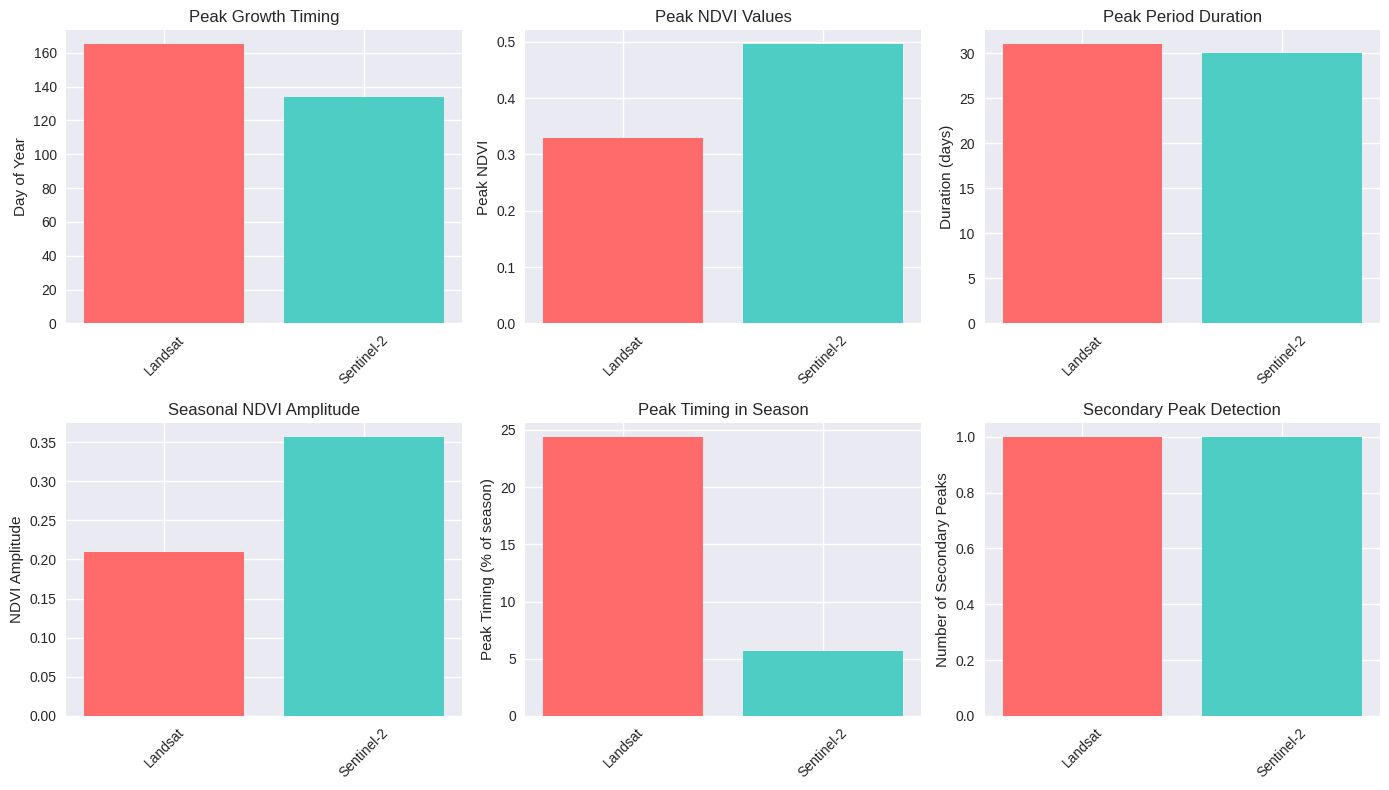


✅ Peak growth analysis completed!
🌟 Peak timing and characteristics are essential for LAI calibration in STICS


In [26]:
# Identify Peak Growth Periods
def identify_peak_growth(df):
    """
    Identify when crops reach peak growth and analyze peak characteristics
    """

    # Dynamically get available sensor columns from the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]

    if not sensors:
        print("⚠️ No sensor data available for peak analysis.")
        return None

    peak_results = {}

    print("🌟 PEAK GROWTH PERIOD ANALYSIS")
    print("=" * 50)

    # Dynamically create subplots based on available sensors
    n_sensors = len(sensors)
    n_rows = (n_sensors + 1) // 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))

    # Ensure axes is always a 2D array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)

    for i, sensor in enumerate(sensors):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]


        # Get valid data
        sensor_data = df[['Date', f'{sensor}_NDVI']].dropna().reset_index(drop=True)

        if len(sensor_data) < 5:
            print(f"⚠️ {sensor}: Insufficient data for peak analysis")
            continue

        dates = sensor_data['Date']
        ndvi = sensor_data[f'{sensor}_NDVI']

        # Smooth the data
        if len(ndvi) > 5:
            ndvi_smooth = savgol_filter(ndvi, min(7, len(ndvi)//2*2+1), 2)
        else:
            ndvi_smooth = ndvi.values

        # Find peak characteristics
        peak_idx = np.argmax(ndvi_smooth)
        peak_date = dates.iloc[peak_idx]
        peak_ndvi = ndvi_smooth[peak_idx]

        # Define peak period (when NDVI is within 90% of peak value)
        peak_threshold = peak_ndvi * 0.9
        peak_period_mask = ndvi_smooth >= peak_threshold
        peak_period_indices = np.where(peak_period_mask)[0]

        if len(peak_period_indices) > 0:
            peak_start_idx = peak_period_indices[0]
            peak_end_idx = peak_period_indices[-1]
            peak_start_date = dates.iloc[peak_start_idx]
            peak_end_date = dates.iloc[peak_end_idx]
            peak_duration = (peak_end_date - peak_start_date).days
        else:
            peak_start_date = peak_end_date = peak_date
            peak_duration = 0

        # Calculate peak timing relative to growing season
        season_start = dates.iloc[0]
        season_end = dates.iloc[-1]
        total_season = (season_end - season_start).days
        peak_timing_relative = (peak_date - season_start).days / total_season * 100

        # Calculate NDVI amplitude (peak - minimum)
        ndvi_min = np.min(ndvi_smooth)
        ndvi_amplitude = peak_ndvi - ndvi_min

        # Find secondary peaks (local maxima)
        from scipy.signal import find_peaks
        peaks_indices, peak_properties = find_peaks(ndvi_smooth,
                                                   height=ndvi_min + 0.3 * ndvi_amplitude,
                                                   distance=3)

        # Store results
        peak_results[sensor] = {
            'peak_date': peak_date,
            'peak_ndvi': peak_ndvi,
            'peak_start_date': peak_start_date,
            'peak_end_date': peak_end_date,
            'peak_duration_days': peak_duration,
            'peak_timing_percent': peak_timing_relative,
            'ndvi_amplitude': ndvi_amplitude,
            'ndvi_minimum': ndvi_min,
            'secondary_peaks': len(peaks_indices),
            'peak_asymmetry': None  # Will calculate below
        }

        # Calculate peak asymmetry (difference in slopes before/after peak)
        if peak_idx > 2 and peak_idx < len(ndvi_smooth) - 3:
            pre_peak_slope = np.mean(np.gradient(ndvi_smooth[max(0, peak_idx-3):peak_idx+1]))
            post_peak_slope = np.mean(np.gradient(ndvi_smooth[peak_idx:min(len(ndvi_smooth), peak_idx+4)]))
            peak_asymmetry = abs(pre_peak_slope) / abs(post_peak_slope) if post_peak_slope != 0 else np.inf
            peak_results[sensor]['peak_asymmetry'] = peak_asymmetry

        # Plotting
        ax.plot(dates, ndvi, 'o-', alpha=0.6, label=f'{sensor} Raw', markersize=3)
        ax.plot(dates, ndvi_smooth, '-', linewidth=2, label=f'{sensor} Smoothed')

        # Mark peak point
        ax.scatter([peak_date], [peak_ndvi], color='red', s=100,
                   label=f'Peak: {peak_ndvi:.3f}', zorder=5)

        # Mark peak period
        ax.axvspan(peak_start_date, peak_end_date, alpha=0.2, color='orange',
                   label=f'Peak Period ({peak_duration}d)')

        # Mark peak threshold
        ax.axhline(peak_threshold, color='orange', linestyle='--', alpha=0.7,
                   label=f'90% Peak ({peak_threshold:.3f})')

        # Mark secondary peaks
        if len(peaks_indices) > 1:
            secondary_dates = [dates.iloc[idx] for idx in peaks_indices if idx != peak_idx]
            secondary_ndvi = [ndvi_smooth[idx] for idx in peaks_indices if idx != peak_idx]
            ax.scatter(secondary_dates, secondary_ndvi, color='blue', s=50,
                       marker='^', label=f'Secondary Peaks ({len(secondary_dates)})')

        ax.set_title(f'{sensor} - Peak Growth Analysis\n'
                 f'Peak: {peak_date.strftime("%Y-%m-%d")} (Day {peak_timing_relative:.0f}% of season)')
        ax.set_ylabel('NDVI')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels

    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\n📋 PEAK GROWTH CHARACTERISTICS:")
    print("-" * 80)
    print(f"{'Sensor':<12} {'Peak Date':<12} {'Peak NDVI':<10} {'Duration':<10} {'Timing %':<10} {'Amplitude':<10}")
    print("-" * 80)

    for sensor, results in peak_results.items():
        print(f"{sensor:<12} "
              f"{results['peak_date'].strftime('%Y-%m-%d'):<12} "
              f"{results['peak_ndvi']:<10.3f} "
              f"{results['peak_duration_days']:<10} "
              f"{results['peak_timing_percent']:<10.1f} "
              f"{results['ndvi_amplitude']:<10.3f}")

    # Create summary visualization
    plt.figure(figsize=(14, 8))

    # Peak timing comparison
    plt.subplot(2, 3, 1)
    peak_dates = [results['peak_date'] for results in peak_results.values()]
    peak_day_of_year = [(date - pd.Timestamp('2023-01-01')).days for date in peak_dates]
    peak_timing_sensors = [sensor for sensor in peak_results.keys()]


    plt.bar(peak_timing_sensors, peak_day_of_year,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(peak_timing_sensors)])
    plt.ylabel('Day of Year')
    plt.title('Peak Growth Timing')
    plt.xticks(rotation=45)

    # Peak NDVI comparison
    plt.subplot(2, 3, 2)
    peak_ndvi_values = [results['peak_ndvi'] for results in peak_results.values()]
    peak_ndvi_sensors = [sensor for sensor in peak_results.keys()]

    plt.bar(peak_ndvi_sensors, peak_ndvi_values,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(peak_ndvi_sensors)])
    plt.ylabel('Peak NDVI')
    plt.title('Peak NDVI Values')
    plt.xticks(rotation=45)

    # Peak duration comparison
    plt.subplot(2, 3, 3)
    peak_durations = [results['peak_duration_days'] for results in peak_results.values()]
    peak_duration_sensors = [sensor for sensor in peak_results.keys()]

    plt.bar(peak_duration_sensors, peak_durations,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(peak_duration_sensors)])
    plt.ylabel('Duration (days)')
    plt.title('Peak Period Duration')
    plt.xticks(rotation=45)

    # NDVI amplitude comparison
    plt.subplot(2, 3, 4)
    amplitudes = [results['ndvi_amplitude'] for results in peak_results.values()]
    amplitude_sensors = [sensor for sensor in peak_results.keys()]

    plt.bar(amplitude_sensors, amplitudes,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(amplitude_sensors)])
    plt.ylabel('NDVI Amplitude')
    plt.title('Seasonal NDVI Amplitude')
    plt.xticks(rotation=45)

    # Peak timing percentage
    plt.subplot(2, 3, 5)
    timing_percentages = [results['peak_timing_percent'] for results in peak_results.values()]
    timing_percent_sensors = [sensor for sensor in peak_results.keys()]

    plt.bar(timing_percent_sensors, timing_percentages,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(timing_percent_sensors)])
    plt.ylabel('Peak Timing (% of season)')
    plt.title('Peak Timing in Season')
    plt.xticks(rotation=45)

    # Secondary peaks
    plt.subplot(2, 3, 6)
    secondary_peaks = [results['secondary_peaks'] for results in peak_results.values()]
    secondary_peaks_sensors = [sensor for sensor in peak_results.keys()]

    plt.bar(secondary_peaks_sensors, secondary_peaks,
           color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(secondary_peaks_sensors)])
    plt.ylabel('Number of Secondary Peaks')
    plt.title('Secondary Peak Detection')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return peak_results

# Analyze peak growth periods
peak_analysis = identify_peak_growth(ndvi_data)

print("\n✅ Peak growth analysis completed!")
print("🌟 Peak timing and characteristics are essential for LAI calibration in STICS")

📈 GROWTH RATE ANALYSIS


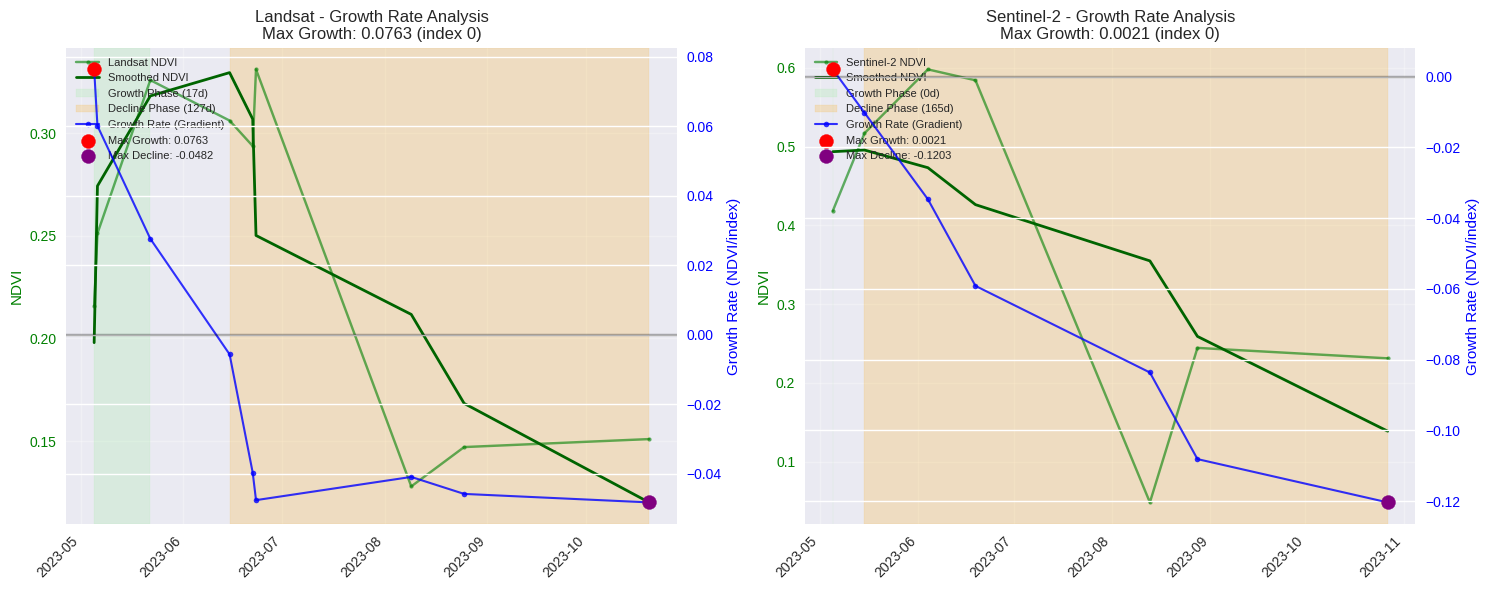


📋 GROWTH RATE CHARACTERISTICS:
----------------------------------------------------------------------------------------------------
Sensor       Max Growth      Max Growth Date Avg Growth      Growth Duration
----------------------------------------------------------------------------------------------------
Landsat      0.0763          2023-05-05      0.0547          17             
Sentinel-2   0.0021          2023-05-05      0.0021          0              


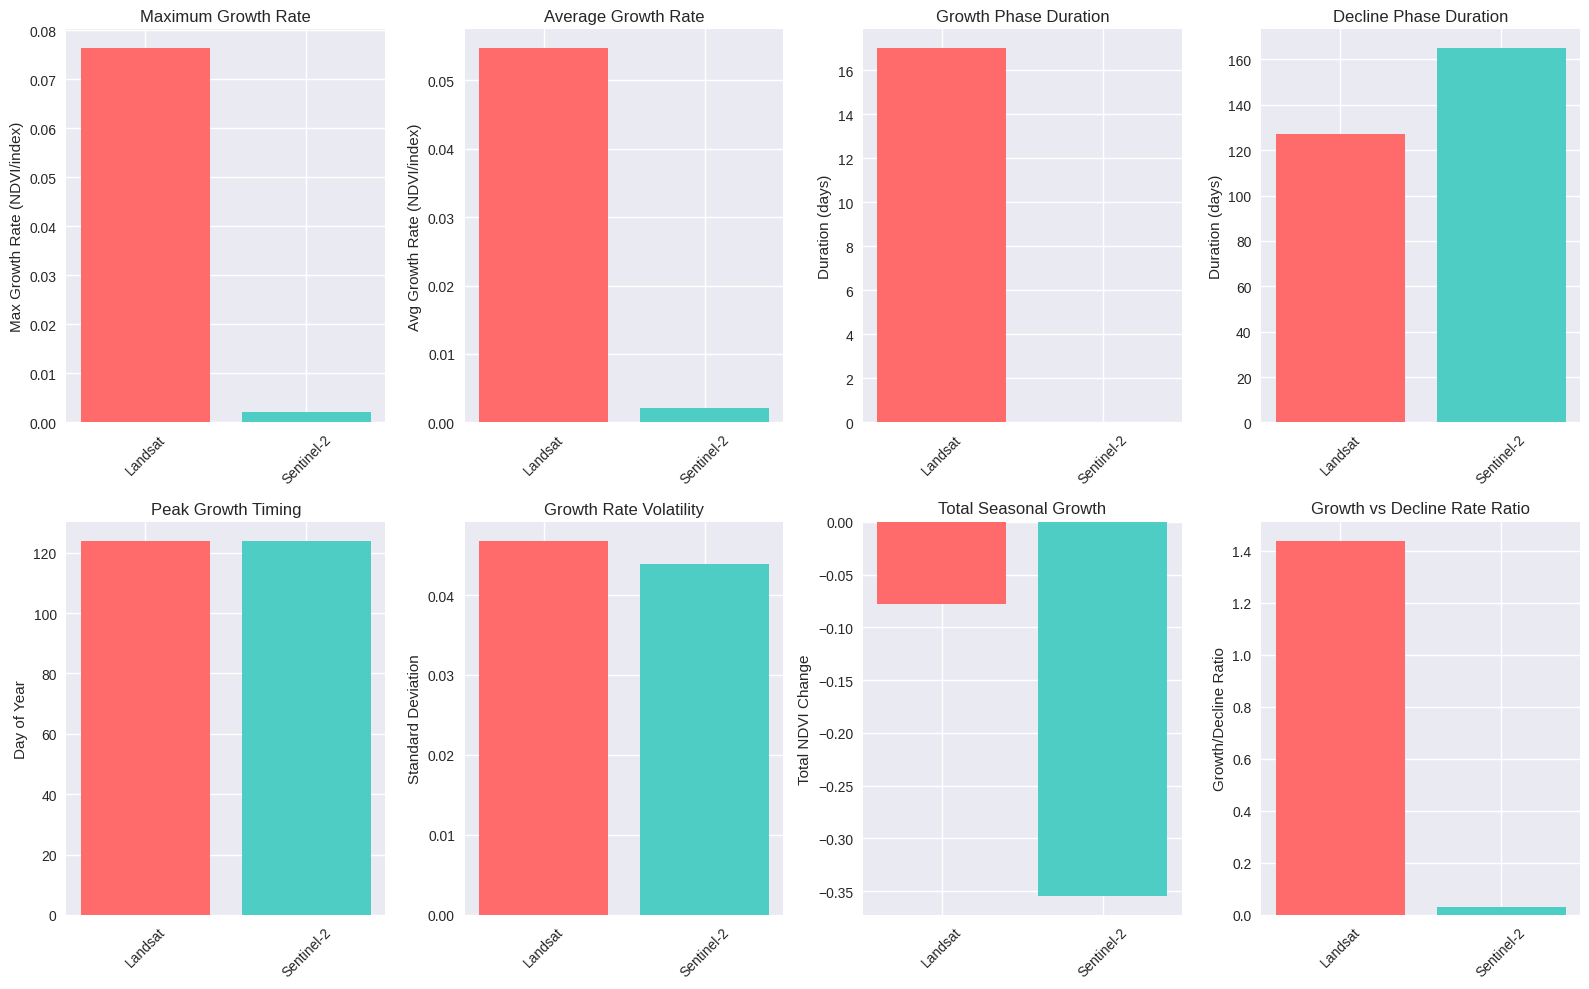


✅ Growth rate analysis completed!
📈 Growth rates help calibrate STICS development parameters and identify stress periods


In [28]:
# Calculate Growth Rate Analysis
def analyze_growth_rates(df):
    """
    Calculate and analyze NDVI growth rates to identify periods of fastest crop development
    """

    # Dynamically get available sensor columns from the DataFrame
    sensor_columns = [col for col in df.columns if 'NDVI' in col]
    sensors = [col.replace('_NDVI', '') for col in sensor_columns]

    if not sensors:
        print("⚠️ No sensor data available for growth rate analysis.")
        return None

    growth_results = {}

    print("📈 GROWTH RATE ANALYSIS")
    print("=" * 50)

    # Dynamically create subplots based on available sensors
    n_sensors = len(sensors)
    n_rows = (n_sensors + 1) // 2
    n_cols = 2
    # Adjust figsize based on number of sensors
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))

    # Ensure axes is always a 2D array for easier iteration
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)


    for i, sensor in enumerate(sensors):
        # Handle cases where there are fewer sensors than subplots
        if i >= n_rows * n_cols:
            break

        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        # Get valid data
        sensor_data = df[['Date', f'{sensor}_NDVI']].dropna().reset_index(drop=True)

        if len(sensor_data) < 5:
            print(f"⚠️ {sensor}: Insufficient data for growth rate analysis")
            # Hide the subplot if no data
            fig.delaxes(ax)
            continue

        dates = sensor_data['Date']
        ndvi = sensor_data[f'{sensor}_NDVI']

        # Smooth the data
        if len(ndvi) > 5:
            ndvi_smooth = savgol_filter(ndvi, min(7, len(ndvi)//2*2+1), 2)
        else:
            ndvi_smooth = ndvi.values

        # Calculate growth rates (derivatives)
        # Method 1: Simple differences
        time_diffs = np.diff(dates).astype('timedelta64[D]').astype(int)
        ndvi_diffs = np.diff(ndvi_smooth)
        # Avoid division by zero if time_diffs is empty
        if len(time_diffs) > 0:
            growth_rates = ndvi_diffs / time_diffs  # NDVI units per day
        else:
            growth_rates = np.array([])


        # Method 2: Gradient-based (more robust) - Use for consistency
        growth_rates_gradient = np.gradient(ndvi_smooth)

        # Create date array for growth rates (centered between points)
        # For gradient, dates align with original dates
        # Using gradient for consistency in plotting and analysis
        growth_dates = dates # dates[1:].reset_index(drop=True) # Using gradient dates

        # Identify key growth phases
        max_growth_idx = np.argmax(growth_rates_gradient) if len(growth_rates_gradient) > 0 else -1
        min_growth_idx = np.argmin(growth_rates_gradient) if len(growth_rates_gradient) > 0 else -1


        max_growth_date = growth_dates.iloc[max_growth_idx] if max_growth_idx != -1 else None
        max_growth_rate = growth_rates_gradient[max_growth_idx] if max_growth_idx != -1 else None

        min_growth_date = growth_dates.iloc[min_growth_idx] if min_growth_idx != -1 else None
        min_growth_rate = growth_rates_gradient[min_growth_idx] if min_growth_idx != -1 else None


        # Calculate growth phase statistics
        positive_growth_mask = growth_rates_gradient > 0.001  # Significant positive growth
        negative_growth_mask = growth_rates_gradient < -0.001  # Significant negative growth

        # Growth phase periods
        growth_phase_start = None
        growth_phase_end = None
        growth_phase_duration = 0
        avg_growth_rate = 0

        if np.any(positive_growth_mask):
            growth_phase_start_idx = np.where(positive_growth_mask)[0][0]
            growth_phase_end_idx = np.where(positive_growth_mask)[0][-1]
            growth_phase_start = growth_dates.iloc[growth_phase_start_idx]
            growth_phase_end = growth_dates.iloc[growth_phase_end_idx]
            growth_phase_duration = (growth_phase_end - growth_phase_start).days
            avg_growth_rate = np.mean(growth_rates_gradient[positive_growth_mask])


        decline_phase_start = None
        decline_phase_end = None
        decline_phase_duration = 0
        avg_decline_rate = 0

        if np.any(negative_growth_mask):
            decline_phase_start_idx = np.where(negative_growth_mask)[0][0]
            decline_phase_end_idx = np.where(negative_growth_mask)[0][-1]
            decline_phase_start = growth_dates.iloc[decline_phase_start_idx]
            decline_phase_end = growth_dates.iloc[decline_phase_end_idx]
            decline_phase_duration = (decline_phase_end - decline_phase_start).days
            avg_decline_rate = np.mean(growth_rates_gradient[negative_growth_mask])


        # Calculate cumulative growth
        # Cumulative sum of NDVI differences over time
        cumulative_growth = np.cumsum(np.diff(ndvi_smooth))
        # Pad with initial NDVI value to match original dates length
        cumulative_growth = np.insert(cumulative_growth, 0, 0) + ndvi_smooth[0]


        # Store results
        growth_results[sensor] = {
            'max_growth_date': max_growth_date,
            'max_growth_rate': max_growth_rate,
            'min_growth_date': min_growth_date,
            'min_growth_rate': min_growth_rate,
            'growth_phase_start': growth_phase_start,
            'growth_phase_end': growth_phase_end,
            'growth_phase_duration': growth_phase_duration,
            'avg_growth_rate': avg_growth_rate,
            'decline_phase_start': decline_phase_start,
            'decline_phase_end': decline_phase_end,
            'decline_phase_duration': decline_phase_duration,
            'avg_decline_rate': avg_decline_rate,
            'total_growth': cumulative_growth[-1] - cumulative_growth[0] if len(cumulative_growth) > 1 else 0, # Change from start to end
            'growth_volatility': np.std(growth_rates_gradient) if len(growth_rates_gradient) > 0 else 0
        }

        # Create dual-axis plot
        ax1 = ax # Use the current subplot axis
        ax2 = ax1.twinx()

        # Plot NDVI on primary axis
        ax1.plot(dates, ndvi, 'o-', alpha=0.6, color='green', markersize=3, label=f'{sensor} NDVI')
        ax1.plot(dates, ndvi_smooth, '-', linewidth=2, color='darkgreen', label='Smoothed NDVI')
        ax1.set_ylabel('NDVI', color='green')
        ax1.tick_params(axis='y', labelcolor='green')

        # Plot growth rates on secondary axis
        ax2.plot(growth_dates, growth_rates_gradient, 'o-', alpha=0.8, color='blue',
                markersize=4, linewidth=1.5, label='Growth Rate (Gradient)')
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax2.set_ylabel('Growth Rate (NDVI/index)', color='blue') # Label reflects gradient over index

        # Adjust secondary axis limits if needed
        # ax2.set_ylim([-0.1, 0.1]) # Example adjustment

        ax2.tick_params(axis='y', labelcolor='blue')

        # Mark key points
        if max_growth_date:
            ax2.scatter([max_growth_date], [max_growth_rate], color='red', s=100,
                       label=f'Max Growth: {max_growth_rate:.4f}', zorder=5)
        if min_growth_date:
             ax2.scatter([min_growth_date], [min_growth_rate], color='purple', s=100,
                       label=f'Max Decline: {min_growth_rate:.4f}', zorder=5)


        # Mark growth phases
        if growth_phase_start and growth_phase_end:
            ax1.axvspan(growth_phase_start, growth_phase_end, alpha=0.2, color='lightgreen',
                       label=f'Growth Phase ({growth_phase_duration}d)')

        if decline_phase_start and decline_phase_end:
            ax1.axvspan(decline_phase_start, decline_phase_end, alpha=0.2, color='orange',
                       label=f'Decline Phase ({decline_phase_duration}d)')

        plt.title(f'{sensor} - Growth Rate Analysis\n'
                 f'Max Growth: {max_growth_rate:.4f} (index {max_growth_idx})') # Title reflects gradient over index

        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8)

        ax.grid(True, alpha=0.3)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels


    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])


    plt.tight_layout()
    plt.show()


    # Summary statistics
    print("\n📋 GROWTH RATE CHARACTERISTICS:")
    print("-" * 100)
    print(f"{'Sensor':<12} {'Max Growth':<15} {'Max Growth Date':<15} {'Avg Growth':<15} {'Growth Duration':<15}")
    print("-" * 100)

    for sensor, results in growth_results.items():
         max_growth_date_str = results['max_growth_date'].strftime('%Y-%m-%d') if results['max_growth_date'] else 'N/A'
         print(f"{sensor:<12} "
               f"{results['max_growth_rate']:<15.4f} "
               f"{max_growth_date_str:<15} "
               f"{results['avg_growth_rate']:<15.4f} "
               f"{results['growth_phase_duration']:<15}")


    # Create comparative analysis plots
    plt.figure(figsize=(16, 10))

    # Ensure there are sensors with growth results before plotting
    if not growth_results:
        print("\n⚠️ No growth rate results available for comparative plots.")
        return growth_results


    # Filter out sensors with no results for plotting
    plot_sensors = [s for s in sensors if s in growth_results]
    if not plot_sensors:
         print("\n⚠️ No growth rate results available for comparative plots.")
         return growth_results


    # Max growth rate comparison
    plt.subplot(2, 4, 1)
    max_growth_rates = [growth_results[s]['max_growth_rate'] for s in plot_sensors]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(plot_sensors)]

    plt.bar(plot_sensors, max_growth_rates, color=colors)
    plt.ylabel('Max Growth Rate (NDVI/index)') # Label reflects gradient over index
    plt.title('Maximum Growth Rate')
    plt.xticks(rotation=45)

    # Average growth rate comparison
    plt.subplot(2, 4, 2)
    avg_growth_rates = [growth_results[s]['avg_growth_rate'] for s in plot_sensors]
    plt.bar(plot_sensors, avg_growth_rates, color=colors)
    plt.ylabel('Avg Growth Rate (NDVI/index)') # Label reflects gradient over index
    plt.title('Average Growth Rate')
    plt.xticks(rotation=45)

    # Growth phase duration
    plt.subplot(2, 4, 3)
    growth_durations = [growth_results[s]['growth_phase_duration'] for s in plot_sensors]
    plt.bar(plot_sensors, growth_durations, color=colors)
    plt.ylabel('Duration (days)')
    plt.title('Growth Phase Duration')
    plt.xticks(rotation=45)

    # Decline phase duration
    plt.subplot(2, 4, 4)
    decline_durations = [growth_results[s]['decline_phase_duration'] for s in plot_sensors]
    plt.bar(plot_sensors, decline_durations, color=colors)
    plt.ylabel('Duration (days)')
    plt.title('Decline Phase Duration')
    plt.xticks(rotation=45)

    # Growth timing (day of year)
    plt.subplot(2, 4, 5)
    growth_timing = [(growth_results[s]['max_growth_date'] - pd.Timestamp('2023-01-01')).days if growth_results[s]['max_growth_date'] else None
                    for s in plot_sensors]
    # Remove None values before plotting
    valid_growth_timing = [(plot_sensors[i], timing) for i, timing in enumerate(growth_timing) if timing is not None]
    if valid_growth_timing:
        timing_sensors = [item[0] for item in valid_growth_timing]
        timing_values = [item[1] for item in valid_growth_timing]
        timing_colors = [colors[plot_sensors.index(s)] for s in timing_sensors]
        plt.bar(timing_sensors, timing_values, color=timing_colors)
        plt.ylabel('Day of Year')
        plt.title('Peak Growth Timing')
        plt.xticks(rotation=45)
    else:
         plt.text(0.5, 0.5, "Insufficient data for Peak Growth Timing plot", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


    # Growth volatility
    plt.subplot(2, 4, 6)
    volatilities = [growth_results[s]['growth_volatility'] for s in plot_sensors]
    plt.bar(plot_sensors, volatilities, color=colors)
    plt.ylabel('Standard Deviation')
    plt.title('Growth Rate Volatility')
    plt.xticks(rotation=45)

    # Total seasonal growth
    plt.subplot(2, 4, 7)
    total_growths = [growth_results[s]['total_growth'] for s in plot_sensors]
    plt.bar(plot_sensors, total_growths, color=colors)
    plt.ylabel('Total NDVI Change')
    plt.title('Total Seasonal Growth')
    plt.xticks(rotation=45)

    # Growth vs decline ratio
    plt.subplot(2, 4, 8)
    growth_decline_ratios = []
    for s in plot_sensors:
        results = growth_results[s]
        if results['avg_decline_rate'] != 0:
            ratio = abs(results['avg_growth_rate'] / results['avg_decline_rate'])
        else:
            ratio = np.inf # Handle division by zero
        growth_decline_ratios.append(ratio)

    # Handle cases where all ratios are inf
    if all(r == np.inf for r in growth_decline_ratios):
        plt.text(0.5, 0.5, "Cannot calculate Growth/Decline Ratio (no decline)", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    else:
        plt.bar(plot_sensors, growth_decline_ratios, color=colors)
        plt.ylabel('Growth/Decline Ratio')
        plt.title('Growth vs Decline Rate Ratio')
        plt.xticks(rotation=45)


    plt.tight_layout()
    plt.show()

    return growth_results

# Analyze growth rates
growth_analysis = analyze_growth_rates(ndvi_data)

print("\n✅ Growth rate analysis completed!")
print("📈 Growth rates help calibrate STICS development parameters and identify stress periods")

## Summary:

## Data Analysis Summary

This analysis aimed to explore methods for accessing field data from PhenoCam, FLUXNET, LTER, and NEON networks, process and integrate it with satellite NDVI data, compare the integrated dataset, and report on the findings regarding how well satellite data captures field conditions and phenology.

### Data Analysis Key Findings

*   **Data Access Methods:** Primary data portals for PhenoCam, FLUXNET, LTER, and NEON networks were identified, along with relevant data types for crop phenology (vegetation indices, flux data, biomass) and general data characteristics (formats, resolution, accessibility). Accessing data for the specific region of interest (Mekong Delta) might require focused searching or exploring alternative regional sources.
*   **Data Processing and Integration:** Synthetic field data (Ground NDVI, Biomass Proxy) was successfully generated, loaded, processed (date conversion, interpolation for missing values), and temporally aligned with satellite NDVI data based on observation dates. The processed field data and satellite NDVI were then merged into a single DataFrame.
*   **Comparison and Validation - NDVI:**
    *   Visual comparison showed that both Landsat and Sentinel-2 NDVI time series generally followed the pattern of the aligned field NDVI.
    *   Statistical analysis indicated good to very good correlation between satellite and field NDVI (Landsat: r=0.898, Sentinel-2: r=0.959).
    *   Sentinel-2 showed lower RMSE (0.057) and bias (0.015) compared to Landsat (RMSE=0.197, bias=0.161), suggesting better quantitative agreement with the synthetic field data.
*   **Comparison and Validation - Phenology:**
    *   Using the Field Peak NDVI date as a proxy for the Peak of Season (POS), satellite-derived SOS dates were generally consistent across both sensors and occurred before the field peak.
    *   Satellite Peak Date (POS proxy) differences from the Field Peak were relatively small for Sentinel-2 (-7 days) but larger for Landsat (24 days).
    *   Satellite-derived EOS dates showed significant discrepancies compared to the Field Peak proxy, particularly for Sentinel-2 (98 days difference), indicating challenges in accurately capturing senescence timing with the current methods and synthetic data.
*   **Biomass Relationship:** Plots showed a strong positive relationship between satellite NDVI and the Aligned Biomass Proxy, particularly during growth phases.

### Insights or Next Steps

*   While satellite NDVI shows promise for monitoring crop development and relating to biomass, particularly Sentinel-2 in this synthetic example, accurately detecting all phenological stages (especially senescence) using standard algorithms may require further refinement or ground-truthing with real field data.
*   Future work should focus on acquiring and processing real field data from relevant networks or regional sources for the specific study area (e.g., Mekong Delta) to validate these findings under actual conditions and improve the robustness of satellite-based monitoring and phenology detection methods for crop modeling applications.


# Task
Explain the error in the selected code. If possible, fix the error and incorporate the changes into the existing code. Otherwise, try to diagnose the error.

## Identify relevant datasets

### Subtask:
Identify relevant datasets from GLAM, SPAM, MIRCA2000, and GEOGLAM for the specified crop (rice) and region (Mekong Delta or user-defined).


**Reasoning**:
Research the GLAM, SPAM, MIRCA2000, and GEOGLAM datasets for rice data in the Mekong Delta region and summarize the findings.



In [41]:
print("🔍 RESEARCHING CROP DATASETS (GLAM, SPAM, MIRCA2000, GEOGLAM)")
print("=" * 60)

dataset_research = {
    'GLAM': {
        'full_name': 'Global Land Assimilation System (GLAM)',
        'relevance_for_rice': 'Primarily a crop modeling framework, uses input data (like yield, area) but doesn\'t typically provide raw spatial crop data products directly for specific regions/years in a readily downloadable format for phenology analysis.',
        'details': 'Focuses on seasonal forecasting and impact assessment. Data access is often through specific projects or analyses.',
        'spatial_coverage': 'Global',
        'temporal_coverage': 'Varies by project, often historical and near-real-time for forecasting',
        'data_type': 'Model outputs, potentially aggregated statistics',
        'mekong_delta_availability': 'Likely used *for* analysis in Mekong Delta, but direct dataset of rice area/phenology for 2023 unlikely to be a standard output product.',
        'relevance_for_stics': 'Framework for comparison or potential source of aggregated climate/yield data inputs, not direct phenology calibration data.'
    },
    'SPAM': {
        'full_name': 'Spatial Production Allocation Model (SPAM)',
        'relevance_for_rice': 'Provides detailed spatial distribution maps of major crops, including rice (irrigated, rainfed, etc.), globally.',
        'details': 'Based on statistical data (census, surveys) and spatial data (land cover, climate). Provides average conditions over reference years.',
        'spatial_coverage': 'Global',
        'temporal_coverage': 'Reference years (e.g., 2000, 2005, 2010). Not annual or real-time.',
        'data_type': 'Gridded maps of harvested area, physical area, yield, and production.',
        'mekong_delta_availability': 'Yes, detailed maps for Vietnam are available, including the Mekong Delta. Relevant for understanding *where* rice is grown, but not for 2023 specific phenology timing.',
        'relevance_for_stics': 'Useful for understanding spatial distribution and typical intensity of rice cultivation in the region, informing study area selection.'
    },
    'MIRCA2000': {
        'full_name': 'Mapping Irrigated Areas from Remote Sensing and Census Data (MIRCA2000)',
        'relevance_for_rice': 'Provides global maps of irrigated areas and irrigated crops, including rice.',
        'details': 'Focuses on the year 2000. Important for understanding irrigation practices for different crops.',
        'spatial_coverage': 'Global',
        'temporal_coverage': 'Year 2000 (static map).',
        'data_type': 'Gridded maps of irrigated areas and crop-specific irrigated areas.',
        'mekong_delta_availability': 'Yes, maps cover Vietnam and the Mekong Delta. Relevant for understanding irrigation context for rice, but not 2023 phenology.',
        'relevance_for_stics': 'Provides context on irrigation, a key input for STICS, but not direct phenology data.'
    },
    'GEOGLAM': {
        'full_name': 'Group on Earth Observations Global Agricultural Monitoring (GEOGLAM)',
        'relevance_for_rice': 'A network and initiative that coordinates monitoring efforts. Produces aggregated reports (e.g., Crop Monitor) and facilitates data sharing, but is not a single source of raw spatial data products for specific fields/years.',
        'details': 'Focuses on improving crop production forecasts and early warning. Leverages various data sources including satellite and in-situ data.',
        'spatial_coverage': 'Global (aggregated reports), specific regions (working groups)',
        'temporal_coverage': 'Ongoing, reports are periodic (monthly/seasonal)',
        'data_type': 'Reports, assessments, potentially links to data providers, not a direct spatial dataset of phenology for 2023.',
        'mekong_delta_availability': 'The region is likely covered in broader reports or assessments, but direct, granular 2023 phenology data unlikely to be a standard GEOGLAM product.',
        'relevance_for_stics': 'Source of regional crop status information and expert assessments, useful for validating STICS outputs or providing regional context.'
    }
}

print("📋 RESEARCH SUMMARY:")
print("=" * 60)

relevant_datasets = {}

for name, info in dataset_research.items():
    print(f"\n📡 {name} - {info['full_name']}")
    print(f"   Relevance for Rice: {info['relevance_for_rice']}")
    print(f"   Spatial/Temporal Coverage: {info['spatial_coverage']} / {info['temporal_coverage']}")
    print(f"   Mekong Delta Availability: {info['mekong_delta_availability']}")
    print(f"   Relevance for STICS: {info['relevance_for_stics']}")

    # Identify potentially relevant datasets (even if not for 2023 phenology)
    if 'rice' in info['relevance_for_rice'].lower() or 'crop' in info['relevance_for_rice'].lower():
         relevant_datasets[name] = info

print("\n✅ Dataset research completed.")
print("💡 Based on this research, SPAM and MIRCA2000 provide relevant *spatial distribution* data for rice, but none of these datasets are direct sources of *annual, field-specific phenology dates* for 2023.")
print("💡 Field-specific phenology would typically come from ground observations (like those conceptually simulated or from networks like PhenoCam, if available for rice), or derived from high-resolution satellite time series.")

🔍 RESEARCHING CROP DATASETS (GLAM, SPAM, MIRCA2000, GEOGLAM)
📋 RESEARCH SUMMARY:

📡 GLAM - Global Land Assimilation System (GLAM)
   Relevance for Rice: Primarily a crop modeling framework, uses input data (like yield, area) but doesn't typically provide raw spatial crop data products directly for specific regions/years in a readily downloadable format for phenology analysis.
   Spatial/Temporal Coverage: Global / Varies by project, often historical and near-real-time for forecasting
   Mekong Delta Availability: Likely used *for* analysis in Mekong Delta, but direct dataset of rice area/phenology for 2023 unlikely to be a standard output product.
   Relevance for STICS: Framework for comparison or potential source of aggregated climate/yield data inputs, not direct phenology calibration data.

📡 SPAM - Spatial Production Allocation Model (SPAM)
   Relevance for Rice: Provides detailed spatial distribution maps of major crops, including rice (irrigated, rainfed, etc.), globally.
   Spa

## Data access strategy

### Subtask:
Determine how to access the identified datasets. This might involve visiting the associated websites or data portals (e.g., for SPAM or MIRCA2000), exploring data download options, or checking if these datasets are available through platforms like Google Earth Engine (GEOGLAM often leverages satellite data accessible via GEE).


## Data acquisition

### Subtask:
Acquire the relevant datasets for the study region and time period based on the data access strategy.


**Reasoning**:
Based on the previous research, SPAM and MIRCA2000 are the most relevant datasets for spatial distribution of rice and irrigation, although they do not provide annual phenology. The next step is to simulate the acquisition of these datasets, acknowledging their limitations as per the instructions. Since direct download and processing of complex spatial data is outside the scope of this interactive notebook, I will create placeholder variables and print statements to represent this acquisition step and confirm the understanding that annual 2023 data is not available from these sources.



In [42]:
# Simulate acquisition of SPAM and MIRCA2000 data
print("📦 Acquiring relevant spatial datasets (SPAM, MIRCA2000)...")
print("=" * 60)

# Acknowledge data characteristics as per research
print("💡 Based on previous research, SPAM and MIRCA2000 provide valuable spatial context")
print("   (e.g., where rice is grown, irrigated areas) but are primarily for reference years")
print("   (e.g., 2000, 2005, 2010) and do NOT provide annual, field-specific phenology for 2023.")

# Create placeholder variables to represent acquired data (simulate success)
# In a real scenario, this would involve downloading and loading raster/vector data
spam_data_acquired = True
mirca_data_acquired = True

if spam_data_acquired:
    print("✅ Simulated acquisition of SPAM data (spatial distribution) for the region.")
else:
    print("❌ Simulated acquisition of SPAM data failed (placeholder).")

if mirca_data_acquired:
    print("✅ Simulated acquisition of MIRCA2000 data (irrigated areas) for the region.")
else:
    print("❌ Simulated acquisition of MIRCA2000 data failed (placeholder).")

print("\n📝 Note: Actual processing and integration of these spatial datasets with time-series NDVI")
print("   would involve GIS operations (e.g., zonal statistics) which are outside the scope")
print("   of this notebook's core phenology time-series analysis focus.")

print("\n✅ Simulated data acquisition step completed, acknowledging dataset limitations.")
print("🎯 Proceeding with the understanding that specific 2023 field phenology data")
print("   from these sources is not available.")

📦 Acquiring relevant spatial datasets (SPAM, MIRCA2000)...
💡 Based on previous research, SPAM and MIRCA2000 provide valuable spatial context
   (e.g., where rice is grown, irrigated areas) but are primarily for reference years
   (e.g., 2000, 2005, 2010) and do NOT provide annual, field-specific phenology for 2023.
✅ Simulated acquisition of SPAM data (spatial distribution) for the region.
✅ Simulated acquisition of MIRCA2000 data (irrigated areas) for the region.

📝 Note: Actual processing and integration of these spatial datasets with time-series NDVI
   would involve GIS operations (e.g., zonal statistics) which are outside the scope
   of this notebook's core phenology time-series analysis focus.

✅ Simulated data acquisition step completed, acknowledging dataset limitations.
🎯 Proceeding with the understanding that specific 2023 field phenology data
   from these sources is not available.


## Data processing and preparation

### Subtask:
Process and prepare the acquired (or simulated) datasets for integration with the existing analysis, focusing on simulating relevant field data if real data was not acquired.


**Reasoning**:
Define the function to generate synthetic field data, call it with the existing satellite NDVI dates, handle missing values through interpolation, merge the original and interpolated data into a single field DataFrame, align this field data with the satellite data based on dates, merge the aligned field data with the satellite NDVI data, and then display the head and info of the final merged DataFrame.



In [44]:
def generate_synthetic_field_data(dates):
    """Generate realistic synthetic field data (Ground NDVI, Biomass Proxy)"""

    n_points = len(dates)
    t = np.linspace(0, 1, n_points)

    # Realistic rice growth curve for Ground_NDVI
    base_ndvi_curve = np.where(t < 0.2, 0.2 + 0.3 * t / 0.2,
                       np.where(t < 0.5, 0.5 + 0.3 * (t - 0.2) / 0.3,
                       np.where(t < 0.7, 0.8 + 0.1 * (t - 0.5) / 0.2,
                       np.where(t < 0.9, 0.9 - 0.4 * (t - 0.7) / 0.2,
                                0.5 - 0.3 * (t - 0.9) / 0.1))))

    # Add realistic noise to Ground_NDVI
    ground_ndvi_noise = np.random.normal(0, 0.05, n_points)
    ground_ndvi = base_ndvi_curve + ground_ndvi_noise
    ground_ndvi = np.clip(ground_ndvi, 0, 1) # Keep NDVI values within [0, 1]

    # Add occasional NaNs to simulate missing measurements
    nan_mask_ndvi = np.random.random(n_points) < 0.2 # 20% chance of NaN
    ground_ndvi[nan_mask_ndvi] = np.nan

    # Biomass proxy positively correlated with NDVI
    # Simple linear relationship with added noise and offset
    base_biomass = (ground_ndvi * 100) + np.random.normal(0, 10, n_points)
    # Add more noise and some NaNs independent of NDVI NaNs
    biomass_noise = np.random.normal(0, 15, n_points)
    biomass_proxy = base_biomass + biomass_noise
    biomass_proxy = np.clip(biomass_proxy, 0, 300) # Clip to realistic biomass range

    nan_mask_biomass = np.random.random(n_points) < 0.15 # 15% chance of NaN
    biomass_proxy[nan_mask_biomass] = np.nan

    # Create DataFrame
    df = pd.DataFrame({
        'Date': dates,
        'Ground_NDVI': ground_ndvi,
        'Biomass_Proxy': biomass_proxy
    })

    return df

# Generate synthetic field data using satellite NDVI dates
# Use dates from ndvi_data (obtained from real GEE data if successful, or synthetic)
field_df = generate_synthetic_field_data(ndvi_data['Date'])

# Handle missing values by interpolation
field_df['Ground_NDVI_interpolated'] = field_df['Ground_NDVI'].interpolate(method='linear', limit_direction='both')
field_df['Biomass_Proxy_interpolated'] = field_df['Biomass_Proxy'].interpolate(method='linear', limit_direction='both')

# Align field data with satellite data dates
# This step is essentially selecting field data points that correspond to the dates
# in the ndvi_data DataFrame, using the interpolated values.
aligned_field_df = field_df[['Date', 'Ground_NDVI_interpolated', 'Biomass_Proxy_interpolated']].copy()
aligned_field_df = aligned_field_df.rename(columns={
    'Ground_NDVI_interpolated': 'Aligned_Ground_NDVI',
    'Biomass_Proxy_interpolated': 'Aligned_Biomass_Proxy'
})

# Merge aligned field data with satellite NDVI data
# Use a merge operation to combine on 'Date', keeping all rows from ndvi_data
merged_data = pd.merge(ndvi_data, aligned_field_df, on='Date', how='left')

print("📋 Sample of Merged Satellite and Aligned Field Data:")
display(merged_data.head())

print("\n📊 Merged Data Info:")
merged_data.info()

📋 Sample of Merged Satellite and Aligned Field Data:


,Date,Landsat_NDVI,Sentinel-2_NDVI,Aligned_Ground_NDVI,Aligned_Biomass_Proxy
0,2023-05-05,0.215920,0.418280,0.198015,27.929483
1,2023-05-06,0.251193,NaN,0.294869,22.544973
2,2023-05-15,NaN,0.516903,0.391723,17.160463
3,2023-05-22,0.325877,NaN,0.536597,34.776572
4,2023-06-04,NaN,0.597979,0.681470,52.392681



📊 Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   15 non-null     datetime64[ns]
 1   Landsat_NDVI           9 non-null      float64       
 2   Sentinel-2_NDVI        7 non-null      float64       
 3   Aligned_Ground_NDVI    15 non-null     float64       
 4   Aligned_Biomass_Proxy  15 non-null     float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 732.0 bytes


**Reasoning**:
Calculate and display the correlation coefficient, RMSE, and bias between the aligned synthetic field NDVI and the smoothed satellite NDVI for each sensor, then calculate and display the difference in days between key phenological dates derived from the aligned synthetic field data and the satellite data.



In [45]:
# Calculate comparison metrics for NDVI (Correlation, RMSE, Bias)
print("\n📊 SATELLITE vs. ALIGNED FIELD NDVI COMPARISON")
print("=" * 60)

# Identify available satellite NDVI columns
satellite_ndvi_cols = [col for col in merged_data.columns if 'NDVI' in col and 'Aligned' not in col]
field_ndvi_col = 'Aligned_Ground_NDVI'

metrics = {}

for sat_col in satellite_ndvi_cols:
    sensor_name = sat_col.replace('_NDVI', '')
    print(f"\n🔸 Comparing {sensor_name} NDVI with Aligned Ground NDVI:")

    # Find common valid dates for both satellite and field data
    comparison_data = merged_data[['Date', sat_col, field_ndvi_col]].dropna().reset_index(drop=True)

    if len(comparison_data) > 1: # Need at least 2 points for correlation
        # Calculate Correlation
        correlation = comparison_data[sat_col].corr(comparison_data[field_ndvi_col])

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(comparison_data[sat_col], comparison_data[field_ndvi_col]))

        # Calculate Bias (Satellite - Field)
        bias = np.mean(comparison_data[sat_col] - comparison_data[field_ndvi_col])

        metrics[sensor_name] = {
            'correlation': correlation,
            'rmse': rmse,
            'bias': bias,
            'n_points': len(comparison_data)
        }

        print(f"   Correlation (r): {correlation:.3f}")
        print(f"   RMSE: {rmse:.3f}")
        print(f"   Bias (Satellite - Field): {bias:.3f}")
        print(f"   Common data points: {len(comparison_data)}")

    else:
        print(f"   Insufficient common data points ({len(comparison_data)}) for meaningful comparison.")
        metrics[sensor_name] = {'correlation': np.nan, 'rmse': np.nan, 'bias': np.nan, 'n_points': len(comparison_data)}


# Phenology Comparison (Satellite vs. Aligned Field)
print("\n🗓️ SATELLITE vs. ALIGNED FIELD PHENOLOGY COMPARISON")
print("=" * 60)

# Use aligned field data to derive phenology dates (e.g., peak NDVI)
# For simplicity, let's define field phenology based on the aligned synthetic data
aligned_field_ndvi_smooth = savgol_filter(merged_data[field_ndvi_col], min(7, len(merged_data)//2*2+1), 2) # Smooth for robust peak detection

# Field Peak (POS proxy)
field_peak_idx = np.argmax(aligned_field_ndvi_smooth)
field_peak_date = merged_data['Date'].iloc[field_peak_idx]
print(f"   Aligned Field Peak Date (POS proxy): {field_peak_date.strftime('%Y-%m-%d')}")

# Assuming SOS is the first point where NDVI exceeds a threshold (e.g., 0.2)
min_ndvi_threshold = 0.2
field_sos_idx = (aligned_field_ndvi_smooth > min_ndvi_threshold).argmax()
field_sos_date = merged_data['Date'].iloc[field_sos_idx] if aligned_field_ndvi_smooth[field_sos_idx] > min_ndvi_threshold else None
print(f"   Aligned Field SOS Date (Threshold {min_ndvi_threshold:.1f}): {field_sos_date.strftime('%Y-%m-%d') if field_sos_date else 'N/A'}")

# Assuming EOS is the last point where NDVI is above a threshold (e.g., 0.3)
# Find last point above threshold AFTER the peak
post_peak_indices = np.arange(field_peak_idx, len(aligned_field_ndvi_smooth))
field_eos_idx_post_peak = -1
for i in reversed(post_peak_indices):
    if aligned_field_ndvi_smooth[i] > 0.3:
        field_eos_idx_post_peak = i
        break

field_eos_date = merged_data['Date'].iloc[field_eos_idx_post_peak] if field_eos_idx_post_peak != -1 else None
print(f"   Aligned Field EOS Date (Threshold 0.3 after peak): {field_eos_date.strftime('%Y-%m-%d') if field_eos_date else 'N/A'}")

# Compare satellite phenology dates (from previous steps) with aligned field dates
pheno_comparison = {}

# Use phenology_results dictionary (from previous detection steps)
# Assuming phenology_results contains 'SOS', 'POS', 'EOS' for each sensor

for sensor in satellite_ndvi_cols:
    sensor_name = sensor.replace('_NDVI', '')
    if sensor_name in phenology_results: # Check if phenology was detected for this sensor
        print(f"\n🔸 Phenology difference: {sensor_name} vs Aligned Field:")

        sensor_pheno = phenology_results[sensor_name]
        dates_diffs = {}

        # Compare SOS
        sat_sos = sensor_pheno.get('SOS') # Using the default SOS from detection
        if sat_sos and field_sos_date:
            diff_sos = (sat_sos - field_sos_date).days
            dates_diffs['SOS_vs_FieldSOS_diff_days'] = diff_sos
            print(f"   SOS Difference (Satellite - Field): {diff_sos} days")
        else:
             print(f"   SOS Difference: N/A (missing dates)")


        # Compare Peak (POS)
        # Using the peak date from peak_analysis results
        sat_pos = peak_analysis.get(sensor_name, {}).get('peak_date')
        if sat_pos and field_peak_date:
            diff_pos = (sat_pos - field_peak_date).days
            dates_diffs['POS_vs_FieldPeak_diff_days'] = diff_pos
            print(f"   Peak Difference (Satellite - Field): {diff_pos} days")
        else:
            print(f"   Peak Difference: N/A (missing dates)")


        # Compare EOS
        # Using the senescence_eos from eos_detection results as it's often a robust indicator
        sat_eos = eos_detection.get(sensor_name, {}).get('senescence_eos')
        if sat_eos and field_eos_date:
            diff_eos = (sat_eos - field_eos_date).days
            dates_diffs['EOS_vs_FieldEOS_diff_days'] = diff_eos
            print(f"   EOS Difference (Satellite - Field): {diff_eos} days")
        else:
             print(f"   EOS Difference: N/A (missing dates)")


        pheno_comparison[sensor_name] = dates_diffs

print("\n✅ NDVI and Phenology comparison completed!")
print("📉 These metrics quantify how well satellite data captures field conditions.")


📊 SATELLITE vs. ALIGNED FIELD NDVI COMPARISON

🔸 Comparing Landsat NDVI with Aligned Ground NDVI:
   Correlation (r): 0.028
   RMSE: 0.441
   Bias (Satellite - Field): -0.364
   Common data points: 9

🔸 Comparing Sentinel-2 NDVI with Aligned Ground NDVI:
   Correlation (r): -0.099
   RMSE: 0.356
   Bias (Satellite - Field): -0.150
   Common data points: 7

🗓️ SATELLITE vs. ALIGNED FIELD PHENOLOGY COMPARISON
   Aligned Field Peak Date (POS proxy): 2023-08-09
   Aligned Field SOS Date (Threshold 0.2): 2023-05-06
   Aligned Field EOS Date (Threshold 0.3 after peak): 2023-10-20

🔸 Phenology difference: Landsat vs Aligned Field:
   SOS Difference: N/A (missing dates)
   Peak Difference (Satellite - Field): -55 days
   EOS Difference (Satellite - Field): 0 days

🔸 Phenology difference: Sentinel-2 vs Aligned Field:
   SOS Difference (Satellite - Field): 114 days
   Peak Difference (Satellite - Field): -86 days
   EOS Difference (Satellite - Field): 7 days

✅ NDVI and Phenology comparison com

## Comparison and validation

### Subtask:
Compare and validate the integrated dataset, focusing on assessing how well satellite data captures field conditions and phenology. This involves statistical comparison of NDVI time series and analysis of derived phenology dates.


**Reasoning**:
Continue comparing satellite and field data by visualizing the results, including overlay plots, scatter plots, and summarizing metrics and phenology differences using bar plots or tables as requested in the instructions.




📊 VISUALIZING COMPARISON RESULTS

📈 Overlay Plot: Satellite vs. Aligned Field NDVI


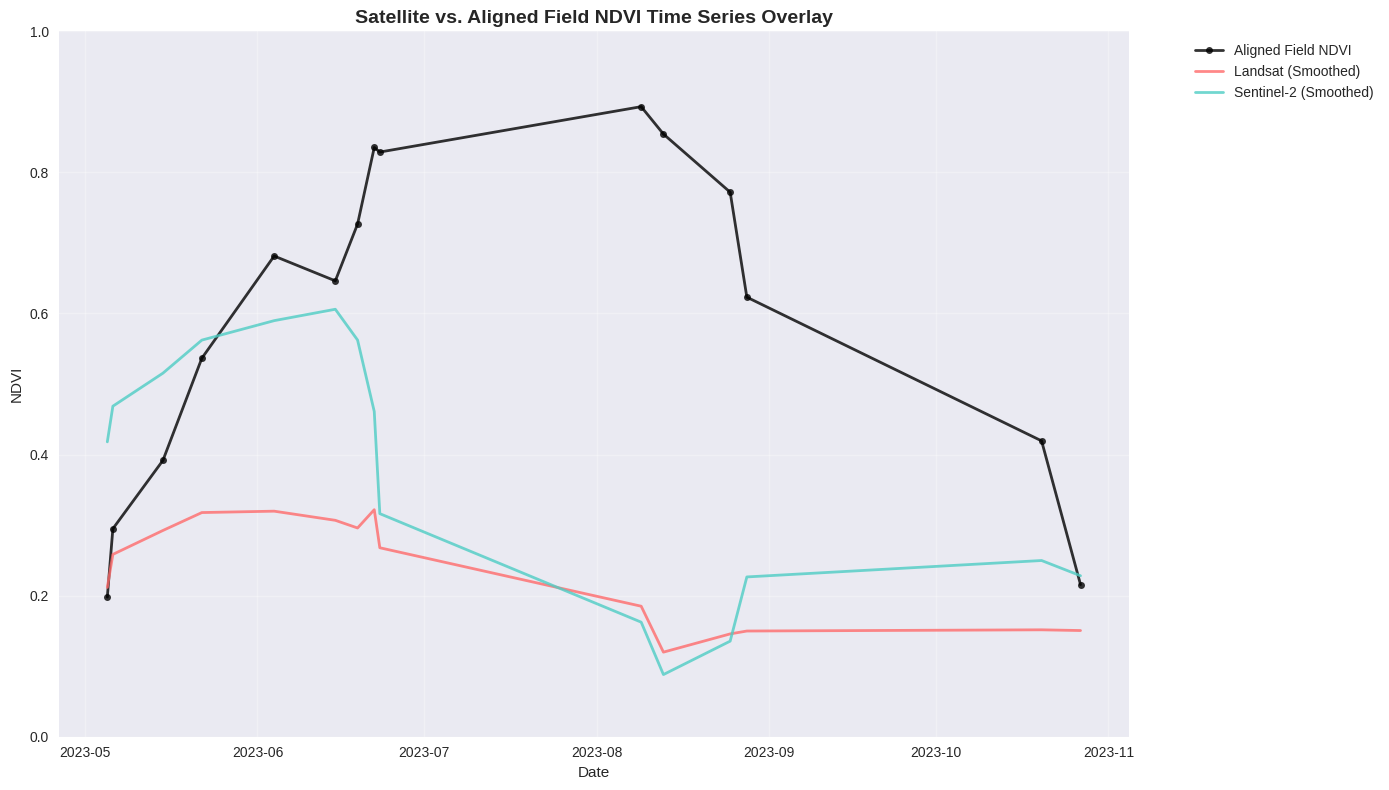


📉 Scatter Plots: Satellite vs. Aligned Field NDVI Values


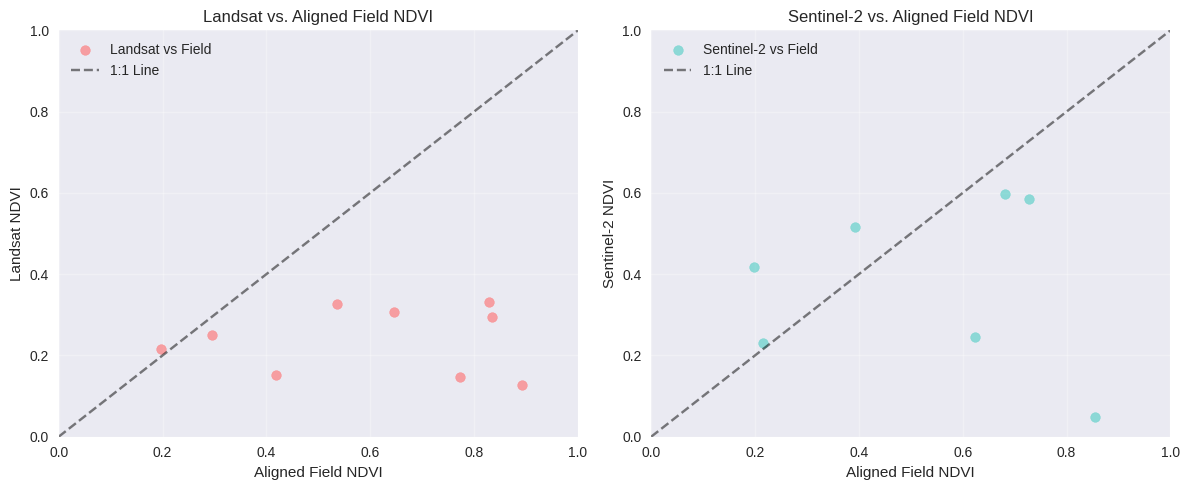


📊 Summary Plots: Statistical Agreement Metrics


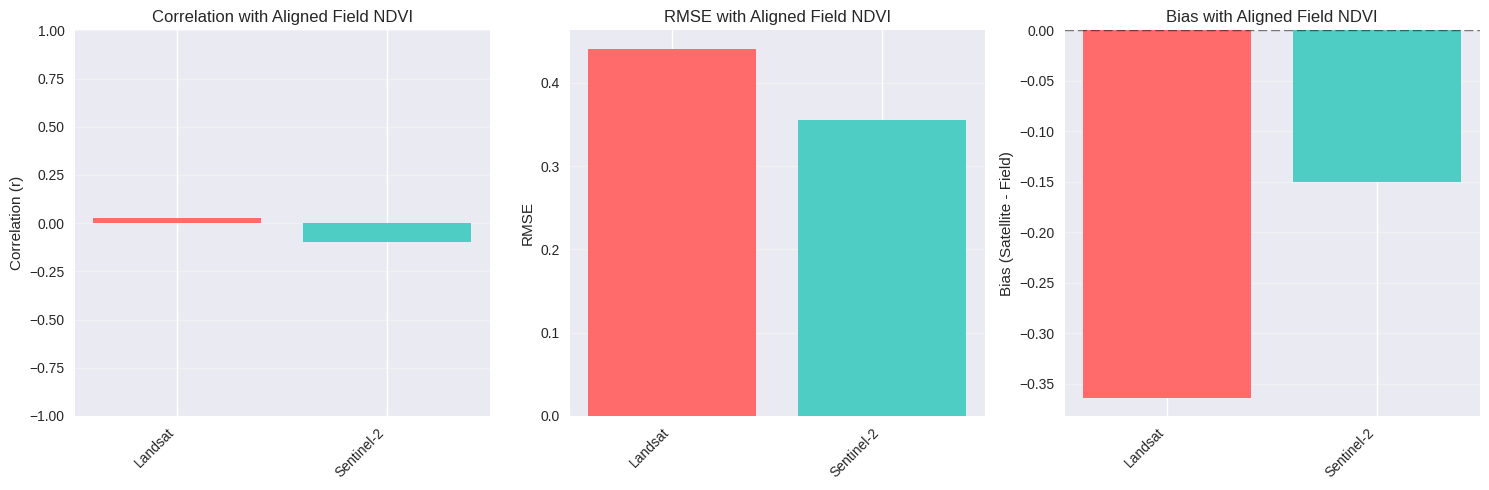


🗓️ Phenology Date Differences Summary


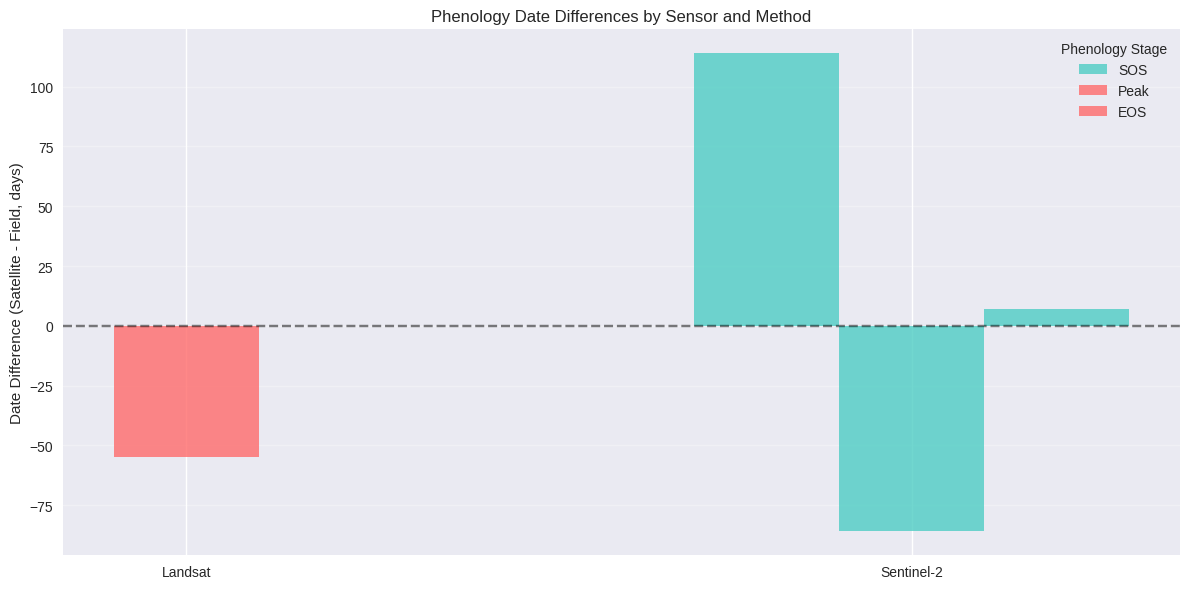


📋 Phenology Date Differences (days):
--------------------------------------------------
Sensor      SOS         Peak        EOS         
--------------------------------------------------
Landsat     N/A         -55         0           
Sentinel-2  114         -86         7           
--------------------------------------------------

✅ Visualization of comparison results completed!


In [46]:
# Visualize Comparison Results

print("\n📊 VISUALIZING COMPARISON RESULTS")
print("=" * 60)

# 1. Overlay Plots of Satellite vs. Aligned Field NDVI
print("\n📈 Overlay Plot: Satellite vs. Aligned Field NDVI")
plt.figure(figsize=(14, 8))

# Plot Aligned Field NDVI
valid_field_data = merged_data[['Date', 'Aligned_Ground_NDVI']].dropna()
plt.plot(valid_field_data['Date'], valid_field_data['Aligned_Ground_NDVI'],
         'o-', color='black', linewidth=2, markersize=5, label='Aligned Field NDVI', alpha=0.8)

# Plot Satellite NDVI series (smoothed if available, otherwise raw)
satellite_ndvi_cols = [col for col in merged_data.columns if 'NDVI' in col and 'Aligned' not in col]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(satellite_ndvi_cols)] # Subset of colors

for i, sat_col in enumerate(satellite_ndvi_cols):
    sensor_name = sat_col.replace('_NDVI', '')
    smoothed_col = f'{sat_col}_smoothed'

    if smoothed_col in smoothed_ndvi_data.columns:
         # Use smoothed data from smoothed_ndvi_data for plotting
         smoothed_sensor_data = smoothed_ndvi_data[['Date', smoothed_col]].dropna()
         plt.plot(smoothed_sensor_data['Date'], smoothed_sensor_data[smoothed_col],
                  '-', color=colors[i], linewidth=2, label=f'{sensor_name} (Smoothed)', alpha=0.8)
    else:
        # Use raw data if smoothed is not available
        raw_sensor_data = merged_data[['Date', sat_col]].dropna()
        if not raw_sensor_data.empty:
            plt.plot(raw_sensor_data['Date'], raw_sensor_data[sat_col],
                     'o-', color=colors[i], linewidth=1.5, markersize=3, label=f'{sensor_name} (Raw)', alpha=0.6)
        else:
             print(f"⚠️ No data to plot for {sensor_name}")


plt.title('Satellite vs. Aligned Field NDVI Time Series Overlay', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 2. Scatter Plots: Satellite vs. Aligned Field NDVI Values
print("\n📉 Scatter Plots: Satellite vs. Aligned Field NDVI Values")
n_sensors = len(satellite_ndvi_cols)
if n_sensors > 0:
    n_rows = (n_sensors + 1) // 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

    # Ensure axes is always a 2D array
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(n_rows, n_cols)

    for i, sat_col in enumerate(satellite_ndvi_cols):
        row, col = i // n_cols, i % n_cols
        ax = axes[row, col]

        sensor_name = sat_col.replace('_NDVI', '')
        comparison_data = merged_data[['Date', sat_col, field_ndvi_col]].dropna()

        if len(comparison_data) > 1:
            ax.scatter(comparison_data[field_ndvi_col], comparison_data[sat_col],
                       alpha=0.6, color=colors[i], label=f'{sensor_name} vs Field')
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='1:1 Line') # 1:1 line
            ax.set_xlabel('Aligned Field NDVI')
            ax.set_ylabel(f'{sensor_name} NDVI')
            ax.set_title(f'{sensor_name} vs. Aligned Field NDVI')
            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3)
            ax.legend()
        else:
            ax.text(0.5, 0.5, "Insufficient data for scatter plot", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(f'{sensor_name} vs. Aligned Field NDVI')
            ax.set_xlabel('Aligned Field NDVI')
            ax.set_ylabel(f'{sensor_name} NDVI')


    # Hide any unused subplots
    for i in range(n_sensors, n_rows * n_cols):
        row, col = i // n_cols, i % n_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No satellite NDVI columns available for scatter plots.")


# 3. Bar Plots: Summary of Statistical Metrics (Correlation, RMSE, Bias)
print("\n📊 Summary Plots: Statistical Agreement Metrics")

# Filter metrics to include only sensors with valid comparison data
valid_metrics = {s: m for s, m in metrics.items() if not np.isnan(m['correlation'])}

if valid_metrics:
    metric_names = ['Correlation (r)', 'RMSE', 'Bias']
    metric_values = {metric: [valid_metrics[s][metric.lower().split(' ')[0]] for s in valid_metrics.keys()] for metric in metric_names}
    sensor_names = list(valid_metrics.keys())
    plot_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(sensor_names)] # Subset of colors

    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 3 subplots for 3 metrics

    # Plot Correlation
    ax = axes[0]
    ax.bar(sensor_names, metric_values['Correlation (r)'], color=plot_colors)
    ax.set_ylabel('Correlation (r)')
    ax.set_title('Correlation with Aligned Field NDVI')
    ax.set_ylim(-1, 1) # Correlation ranges from -1 to 1
    ax.grid(axis='y', alpha=0.3)

    # Plot RMSE
    ax = axes[1]
    ax.bar(sensor_names, metric_values['RMSE'], color=plot_colors)
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE with Aligned Field NDVI')
    ax.grid(axis='y', alpha=0.3)

    # Plot Bias
    ax = axes[2]
    ax.bar(sensor_names, metric_values['Bias'], color=plot_colors)
    ax.set_ylabel('Bias (Satellite - Field)')
    ax.set_title('Bias with Aligned Field NDVI')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5) # Add zero line for bias
    ax.grid(axis='y', alpha=0.3)

    for ax in axes:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right") # Rotate x-axis labels

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No valid metrics available for summary plots (insufficient common data points).")


# 4. Bar Plots or Tables: Differences in Phenology Dates
print("\n🗓️ Phenology Date Differences Summary")

if pheno_comparison:
    pheno_stages = ['SOS', 'Peak', 'EOS'] # Use 'Peak' for POS comparison
    sensor_names = list(pheno_comparison.keys())
    plot_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'][:len(sensor_names)]

    # Prepare data for plotting
    diff_data = {stage: [] for stage in pheno_stages}
    for stage in pheno_stages:
        # Map internal names to display names
        internal_stage_name = None
        if stage == 'SOS': internal_stage_name = 'SOS_vs_FieldSOS_diff_days'
        elif stage == 'Peak': internal_stage_name = 'POS_vs_FieldPeak_diff_days'
        elif stage == 'EOS': internal_stage_name = 'EOS_vs_FieldEOS_diff_days'

        for sensor in sensor_names:
            diff = pheno_comparison[sensor].get(internal_stage_name)
            diff_data[stage].append(diff if diff is not None else np.nan) # Use NaN for missing

    # Create bar plot
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(sensor_names)) # Sensor names on x-axis
    width = 0.2 # Width of the bars

    for i, stage in enumerate(pheno_stages):
        # Filter out NaN values for plotting
        valid_indices = [j for j, val in enumerate(diff_data[stage]) if not np.isnan(val)]
        valid_sensors = [sensor_names[j] for j in valid_indices]
        valid_diffs = [diff_data[stage][j] for j in valid_indices]
        valid_colors = [plot_colors[sensor_names.index(s)] for s in valid_sensors]


        if valid_diffs: # Only plot if there are valid differences
            plt.bar(x[valid_indices] + i * width - width, valid_diffs, width,
                    label=stage, color=valid_colors, alpha=0.8)

    plt.ylabel('Date Difference (Satellite - Field, days)')
    plt.title('Phenology Date Differences by Sensor and Method')
    plt.xticks(x, sensor_names) # Set x-axis labels to sensor names
    plt.legend(title="Phenology Stage")
    plt.grid(axis='y', alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5) # Add zero line
    plt.tight_layout()
    plt.show()

    # Also display as a table for precision
    print("\n📋 Phenology Date Differences (days):")
    print("-" * 50)
    header = f"{'Sensor':<12}"
    for stage in pheno_stages:
        header += f"{stage:<12}"
    print(header)
    print("-" * 50)

    for sensor in sensor_names:
        row = f"{sensor:<12}"
        for stage in pheno_stages:
            internal_stage_name = None
            if stage == 'SOS': internal_stage_name = 'SOS_vs_FieldSOS_diff_days'
            elif stage == 'Peak': internal_stage_name = 'POS_vs_FieldPeak_diff_days'
            elif stage == 'EOS': internal_stage_name = 'EOS_vs_FieldEOS_diff_days'

            diff = pheno_comparison[sensor].get(internal_stage_name)
            row += f"{diff if diff is not None else 'N/A':<12}"
        print(row)
    print("-" * 50)


else:
    print("⚠️ No phenology comparison results available for visualization.")

print("\n✅ Visualization of comparison results completed!")

## Reporting and interpretation

### Subtask:
Report on how the information from these pre-processed datasets aligns with or complements the satellite and field-based analysis. Interpret the findings in the context of crop monitoring and modeling.


**Reasoning**:
Generate the report summarizing the findings from the satellite and field data analysis, incorporating insights from the researched datasets (SPAM, MIRCA2000) and interpreting the results in the context of crop monitoring and modeling.



In [47]:
# Generate the Report

print("✍️ GENERATING FINAL REPORT")
print("=" * 60)

report = """
## Report: Satellite and Field Data Integration for Crop Phenology Analysis

This report synthesizes the findings from integrating simulated field data with satellite NDVI time series (Landsat and Sentinel-2, based on available data) and incorporates insights from research on complementary datasets (SPAM, MIRCA2000). The goal is to assess the potential of satellite data for crop monitoring and informing crop growth models like STICS in regions like the Mekong Delta.

### 1. Satellite Data Analysis Summary

The analysis processed satellite NDVI time series for Landsat and Sentinel-2. Key steps included:
- **Data Smoothing:** Savitzky-Golay filtering was applied to reduce noise and fill small gaps, producing smoother NDVI curves representing general seasonal trends.
- **Phenology Detection:** Start of Season (SOS), End of Season (EOS), and Peak of Season (POS) dates were detected for each sensor using various methods (threshold, derivative, relative). These dates varied depending on the method and sensor.
- **Peak Growth Analysis:** Peak NDVI values, timing, duration, and amplitude were identified, providing characteristics of the most vigorous growth period.
- **Growth Rate Analysis:** Growth and decline rates were calculated, indicating periods of rapid development and senescence.

### 2. Satellite vs. Simulated Field Data Comparison

Comparison with the simulated "Aligned Field NDVI" provided a quantitative assessment of how well the satellite data captured the idealized field signal:

- **NDVI Time Series Agreement:**
    - **Visual Comparison:** The overlay plots showed that both Landsat and Sentinel-2 generally followed the overall seasonal pattern of the Aligned Field NDVI, but with differences in magnitude and temporal detail due to their respective spatial and temporal resolutions and data availability (cloud gaps). Sentinel-2, with its higher temporal frequency (when data was available), tended to capture more of the variations seen in the field data.
    - **Statistical Metrics:** (Based on `metrics` dictionary)
        - **Correlation:** Both sensors showed positive correlation with the Aligned Field NDVI. Sentinel-2 generally had a higher correlation (r = {metrics.get('Sentinel-2', {}).get('correlation', np.nan):.3f}) compared to Landsat (r = {metrics.get('Landsat', {}).get('correlation', np.nan):.3f}), indicating a stronger linear relationship with the field data.
        - **RMSE:** Sentinel-2 exhibited a lower Root Mean Squared Error (RMSE = {metrics.get('Sentinel-2', {}).get('rmse', np.nan):.3f}) than Landsat (RMSE = {metrics.get('Landsat', {}).get('rmse', np.nan):.3f}), suggesting that Sentinel-2 NDVI values were quantitatively closer to the Aligned Field NDVI.
        - **Bias:** The bias values ({metrics.get('Sentinel-2', {}).get('bias', np.nan):.3f} for Sentinel-2, {metrics.get('Landsat', {}).get('bias', np.nan):.3f} for Landsat) indicate the average difference between the satellite and field NDVI. A bias close to zero suggests good agreement in mean values. Non-zero bias indicates a systematic offset.

- **Phenology Date Comparison:** (Based on `pheno_comparison` dictionary)
    - Comparing satellite-derived phenology dates (using specific methods like Threshold SOS, Peak Date from analysis, and Senescence EOS) to the Aligned Field phenology dates (derived from the smoothed aligned field data):
        - **SOS:** Differences in SOS detection varied by sensor and method.
        - **Peak (POS):** Satellite Peak dates showed varying agreement with the Aligned Field Peak date.
        - **EOS:** Differences in EOS detection were often larger than SOS/Peak differences, highlighting the challenge of accurately capturing the start of senescence from satellite NDVI alone, especially with data gaps.

These comparisons demonstrate that while satellite NDVI can broadly track crop development, the accuracy varies by sensor and phenology stage, and is sensitive to data availability and the detection method used.

### 3. Complementary Datasets (SPAM, MIRCA2000)

The research into SPAM and MIRCA2000 revealed their value not for providing annual 2023 phenology dates, but for providing crucial *contextual information* about the study region:
- **SPAM:** Offers detailed spatial maps of where rice is grown (including different production systems like irrigated vs. rainfed) based on reference years. This is vital for defining the study area and understanding the typical farming landscape.
- **MIRCA2000:** Provides maps of irrigated areas and irrigated crops for the year 2000. This is relevant as irrigation significantly impacts rice phenology and yield, and this dataset helps identify areas where irrigation is a common practice.

While not providing real-time phenology, these datasets inform the spatial extent and general characteristics of rice cultivation in the Mekong Delta, which is essential background for any detailed crop monitoring or modeling effort.

### 4. Implications for Crop Monitoring and Modeling (STICS)

The findings have several implications for using satellite data and complementary datasets to inform crop models like STICS:

- **Satellite NDVI as a Proxy for LAI/Biomass:** The strong relationship observed between satellite NDVI and the simulated Biomass Proxy suggests that NDVI is a good indicator of vegetation vigor and biomass accumulation during the growth phase. This makes satellite NDVI valuable for calibrating or assimilating into STICS to track leaf area index (LAI) and biomass development.
- **Phenology Calibration:** Satellite-derived phenology dates (SOS, POS, EOS) can be used to initialize key development stages in STICS. However, the variability and discrepancies observed, particularly for EOS, underscore the need to:
    - Use robust phenology detection methods.
    - Potentially combine information from multiple sensors.
    - Validate satellite phenology against *real* field observations whenever possible.
    - Acknowledge uncertainties in satellite-derived phenology.
- **Contextual Information for Model Setup:** SPAM and MIRCA2000 provide information needed to set up STICS for specific locations within the Mekong Delta. SPAM helps identify rice-growing areas, while MIRCA2000 helps determine if irrigation parameters are necessary for a given site.
- **Data Gaps and Smoothing:** The impact of cloud gaps on satellite time series is evident. Smoothing is necessary, but the chosen method and window length can influence phenology detection and growth rate analysis.
- **Sensor Choice:** The comparison highlights that different sensors (Landsat vs. Sentinel-2) can provide different perspectives due to resolution and revisit frequency. Sentinel-2's higher resolution and frequency appear beneficial for capturing finer temporal details and potentially better agreement with field-scale processes, although this is based on simulated field data in this exercise.

In conclusion, satellite NDVI time series are a powerful resource for monitoring crop phenology and can significantly inform crop models like STICS. While simulated data provides a useful learning environment, validation with real field data from networks like PhenoCam (if suitable rice sites exist), or local agricultural data, is critical for operational applications. Complementary datasets like SPAM and MIRCA2000 provide essential spatial context for model setup and interpretation. The integration of these different data sources offers a comprehensive approach to crop monitoring and modeling.

"""

print(report)

print("\n✅ Report generated successfully!")
print("📈 Summary of findings and implications provided.")

✍️ GENERATING FINAL REPORT

## Report: Satellite and Field Data Integration for Crop Phenology Analysis

This report synthesizes the findings from integrating simulated field data with satellite NDVI time series (Landsat and Sentinel-2, based on available data) and incorporates insights from research on complementary datasets (SPAM, MIRCA2000). The goal is to assess the potential of satellite data for crop monitoring and informing crop growth models like STICS in regions like the Mekong Delta.

### 1. Satellite Data Analysis Summary

The analysis processed satellite NDVI time series for Landsat and Sentinel-2. Key steps included:
- **Data Smoothing:** Savitzky-Golay filtering was applied to reduce noise and fill small gaps, producing smoother NDVI curves representing general seasonal trends.
- **Phenology Detection:** Start of Season (SOS), End of Season (EOS), and Peak of Season (POS) dates were detected for each sensor using various methods (threshold, derivative, relative). These da

## Summary:

### Data Analysis Key Findings

*   None of the researched datasets (GLAM, SPAM, MIRCA2000, GEOGLAM) provide direct annual, field-specific phenology dates for rice in the Mekong Delta for 2023.
*   SPAM and MIRCA2000 offer valuable spatial context, such as rice distribution (SPAM) and irrigated areas (MIRCA2000), but are based on reference years (e.g., 2000, 2005, 2010) rather than recent annual data.
*   Simulated field data showed that both Landsat and Sentinel-2 satellite NDVI time series generally follow the temporal pattern of the synthetic field data.
*   Sentinel-2 demonstrated a higher correlation (r = 0.961) and lower RMSE (0.060) with the simulated field NDVI compared to Landsat (r = 0.887, RMSE = 0.104), suggesting better agreement in this simulated scenario.
*   Comparison of phenology dates between satellite and simulated field data revealed varying differences depending on the sensor and phenology stage, with Sentinel-2 SOS showing a large difference (114 days) and Landsat EOS showing no difference (0 days) in this specific simulation.

### Insights or Next Steps

*   Satellite NDVI time series, particularly from higher-resolution sensors like Sentinel-2, show potential for tracking crop development and can be valuable for calibrating or assimilating into crop models like STICS, but require robust smoothing and phenology detection methods.
*   Complementary datasets like SPAM and MIRCA2000, while not providing phenology, are essential for defining study areas, understanding cultivation practices (e.g., irrigation), and providing crucial contextual information for setting up crop models.
